<a href="https://colab.research.google.com/github/sankarvinayak/RL-assignments/blob/main/CS24M041_QLearning_SARSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Run this only if you are using Google Colab
from google.colab import drive
import os

drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:

# change path here as per your directory structure
os.chdir('drive/My Drive/RL/Tutorial 4')

In [ ]:
# Install relevant libraries
!pip install numpy matplotlib tqdm scipy

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
%matplotlib inline

# Problem Statement

In this section we will implement tabular SARSA and Q-learning algorithms for a grid world navigation task.

## Environment details
The agent can move from one grid coordinate to one of its adjacent grids using one of the four actions: UP, DOWN, LEFT and RIGHT. The goal is to go from a randomly assigned starting position to goal position.

Actions that can result in taking the agent off the grid will not yield any effect.
Lets look at the environment.


In [ ]:
DOWN = 0
UP = 1
LEFT = 2
RIGHT = 3
actions = [DOWN, UP, LEFT, RIGHT]

Let us construct a grid in a text file.

In [ ]:
!cat grid_world2.txt

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
1 1 1 1 1 1 2 2 2 1 1 1 1 0 0 0 0 0 0 0 0 0 0
0 0 0 1 1 1 2 2 2 1 1 1 1 0 0 0 0 0 0 0 0 0 0
0 0 0 1 1 1 2 2 2 1 1 1 1 0 0 0 0 0 0 0 0 0 0
0 0 0 1 1 1 2 2 2 1 1 1 1 0 0 0 0 0 0 0 0 0 0
0 0 0 1 1 1 2 2 2 1 1 1 1 0 0 0 0 0 0 0 0 0 0
0 0 0 1 1 1 2 2 2 1 1 1 1 0 0 0 0 0 0 0 0 0 0
0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


This is a $17\times 23$ grid. The reward when an agent goes to a cell is negative of the value in that position in the text file (except if it is the goal cell). We will define the goal reward as 100. We will also fix the maximum episode length to 10000.

Now let's make it more difficult. We add stochasticity to the environment: with probability 0.2 agent takes a random action (which can be other than the chosen action).
There is also a westerly wind blowing (to the right). Hence, after every time-step, with probability 0.5 the agent also moves an extra step to the right.

Now let's plot the grid world.

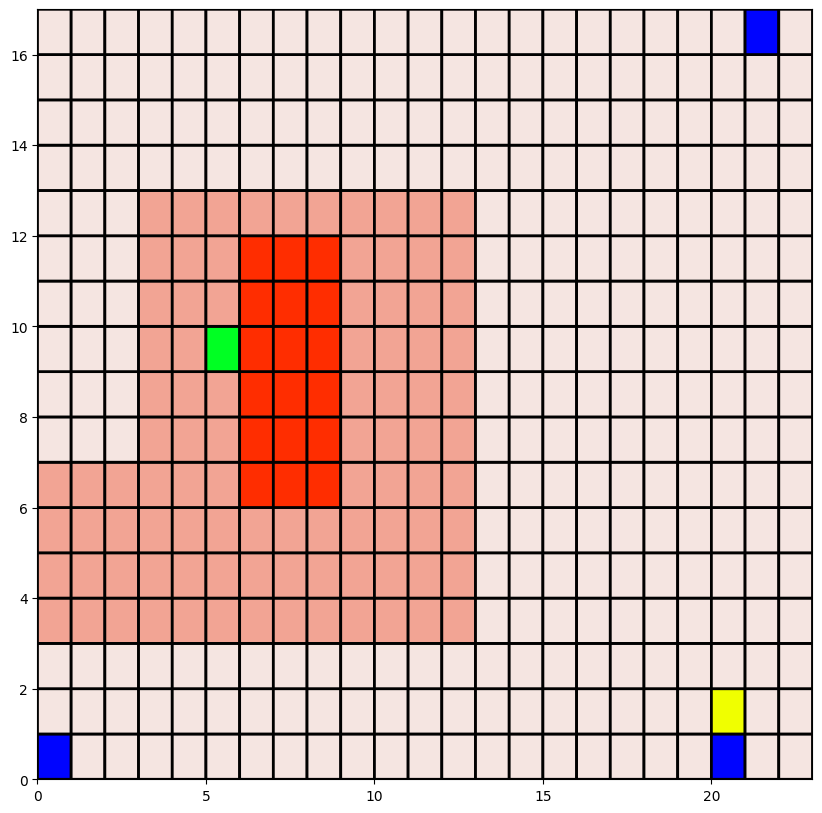

In [ ]:
world = 'grid_world2.txt'
goal_reward = 100
start_states = [(0,0), (0,20), (16,21)]
goal_states=[(9,5)]
max_steps=10000

from grid_world import GridWorldEnv, GridWorldWindyEnv

env = GridWorldEnv(world, goal_reward=goal_reward, start_states=start_states, goal_states=goal_states,
                max_steps=max_steps, action_fail_prob=0.2)
plt.figure(figsize=(10, 10))
# Go UP
env.step(UP)
env.render(ax=plt, render_agent=True)

### Legend
- <span style="color:#0004FF">*Blue*</span> is the **start state**.
- <span style="color:#00FF23">*Green*</span> is the **goal state**.
- <span style="color:#F0FF00">*Yellow*</span> is current **state of the agent**.
- <span style="color:#FF2D00">*Redness*</span> denotes the extent of **negative reward**.

### Q values
We can use a 3D array to represent Q values. The first two indices are X, Y coordinates and last index is the action.

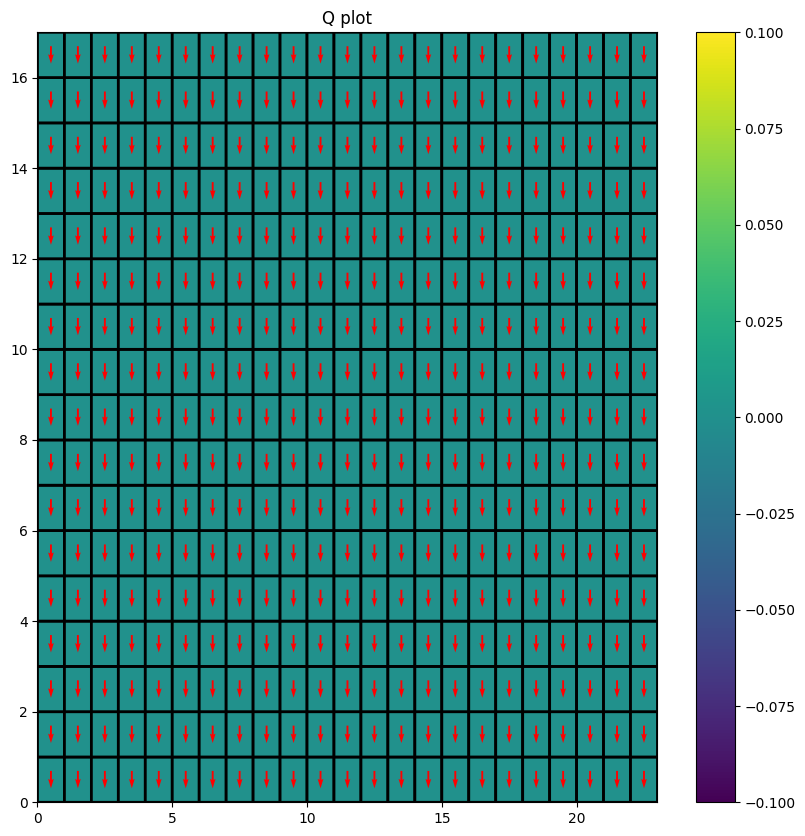

(17, 23, 4)

In [ ]:
from grid_world import plot_Q

Q = np.zeros((env.grid.shape[0], env.grid.shape[1], len(env.action_space)))

plot_Q(Q)

Q.shape

### Exploration strategies
1. Epsilon-greedy
2. Softmax

In [ ]:
from scipy.special import softmax

seed = 42
rg = np.random.RandomState(seed)

# Epsilon greedy
def choose_action_epsilon(Q, state, epsilon, rg=rg):
    if not Q[state[0], state[1]].any() or rg.rand() < epsilon:
        return rg.choice(Q.shape[-1])
    else:
        return np.argmax(Q[state[0], state[1]])

# Softmax
def choose_action_softmax(Q, state, rg=rg):
    return rg.choice(Q.shape[-1], p = softmax(Q[state[0], state[1]]))

## SARSA
Now we implement the SARSA algorithm.

Recall the update rule for SARSA:
\begin{equation}
Q(s_t,a_t) \leftarrow  Q(s_t, a_t) + \alpha[r_t + \gamma Q(s_{t+1}, a_{t+1}) - Q(s_t, a_t)]
\end{equation}

### Hyperparameters

So we have som hyperparameters for the algorithm:
- $\alpha$
- number of *episodes*.
- $\epsilon$: For epsilon greedy exploration

In [ ]:
# initialize Q-value
Q = np.zeros((env.grid.shape[0], env.grid.shape[1], len(env.action_space)))

alpha0 = 0.4
gamma = 0.9
episodes = 10000
epsilon0 = 0.1

Let's implement SARSA

In [ ]:
print_freq = 100

def sarsa(env, Q, gamma = 0.9, plot_heat = False, choose_action = choose_action_softmax,episodes = 10000):

    episode_rewards = np.zeros(episodes)
    steps_to_completion = np.zeros(episodes)
    if plot_heat:
        clear_output(wait=True)
        plot_Q(Q)
    epsilon = epsilon0
    alpha = alpha0
    for ep in tqdm(range(episodes)):
        tot_reward, steps = 0, 0

        # Reset environment
        state = env.reset()
        action = choose_action(Q, state)
        done = False
        while not done:
            state_next, reward, done = env.step(action)
            action_next = choose_action(Q, state_next)

            # update equation
            Q[state[0], state[1], action] += alpha*(reward + gamma*Q[state_next[0], state_next[1], action_next] - Q[state[0], state[1], action])

            tot_reward += reward
            steps += 1

            state, action = state_next, action_next

        episode_rewards[ep] = tot_reward
        steps_to_completion[ep] = steps

        if (ep+1)%print_freq == 0 and plot_heat:
            clear_output(wait=True)
            plot_Q(Q, message = "Episode %d: Reward: %f, Steps: %.2f, Qmax: %.2f, Qmin: %.2f"%(ep+1, np.mean(episode_rewards[ep-print_freq+1:ep]),
                                                                           np.mean(steps_to_completion[ep-print_freq+1:ep]),
                                                                           Q.max(), Q.min()))

    return Q, episode_rewards, steps_to_completion

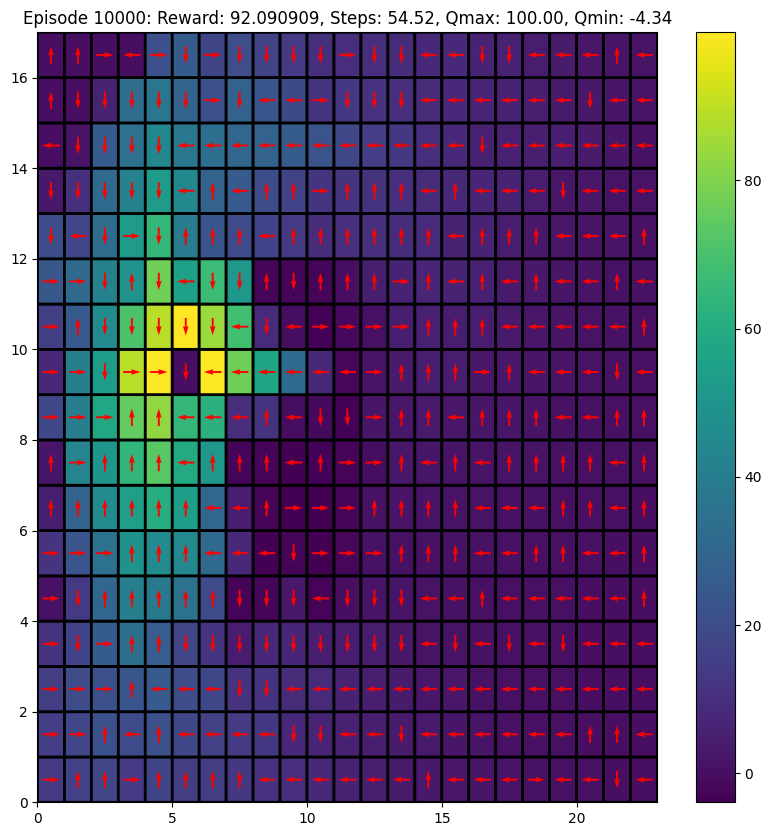

100%|██████████| 10000/10000 [01:53<00:00, 88.36it/s]


In [ ]:
Q, rewards, steps = sarsa(env, Q, gamma = gamma, plot_heat=True, choose_action= choose_action_softmax)

### Visualizing the policy
Now let's see the agent in action.
Run the below cell (as many times) to render the policy;

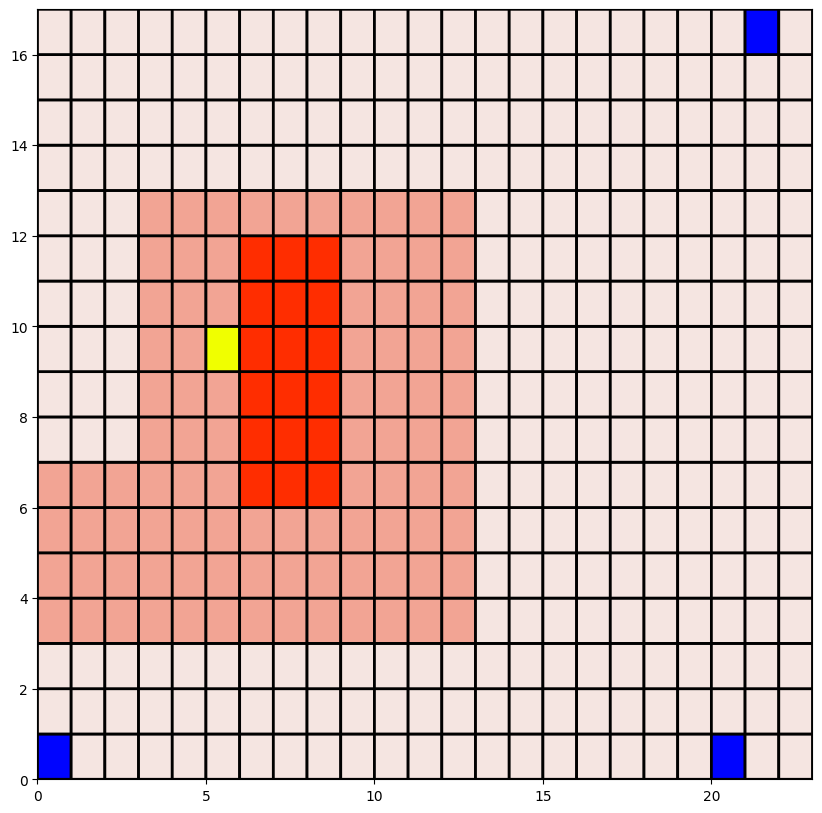

Steps: 21, Total Reward: 91


In [ ]:
from time import sleep

state = env.reset()
done = False
steps = 0
tot_reward = 0
while not done:
    clear_output(wait=True)
    state, reward, done = env.step(Q[state[0], state[1]].argmax())
    plt.figure(figsize=(10, 10))
    env.render(ax=plt, render_agent=True)
    plt.show()
    steps += 1
    tot_reward += reward
    sleep(0.2)
print("Steps: %d, Total Reward: %d"%(steps, tot_reward))

### Analyzing performance of the policy
We use two metrics to analyze the policies:

1. Average steps to reach the goal
2. Total rewards from the episode

To ensure, we account for randomness in environment and algorithm (say when using epsilon-greedy exploration), we run the algorithm for multiple times and use the average of values over all runs.

In [ ]:
Q_sarsa_avgs, sarsa_reward_avgs, sarsa_steps_avgs = [], [], []
num_expts = 5

for i in range(num_expts):
    print("Experiment: %d"%(i+1))
    Q = np.zeros((env.grid.shape[0], env.grid.shape[1], len(env.action_space)))
    rg = np.random.RandomState(i)
    Q, rewards, steps = sarsa(env, Q)
    Q_sarsa_avgs.append(Q.copy())
    sarsa_reward_avgs.append(rewards)
    sarsa_steps_avgs.append(steps)

Experiment: 1


100%|██████████| 10000/10000 [00:43<00:00, 232.48it/s]


Experiment: 2


100%|██████████| 10000/10000 [00:48<00:00, 206.39it/s]


Experiment: 3


100%|██████████| 10000/10000 [00:54<00:00, 183.39it/s]


Experiment: 4


100%|██████████| 10000/10000 [00:49<00:00, 203.33it/s]


Experiment: 5


100%|██████████| 10000/10000 [00:46<00:00, 214.10it/s]


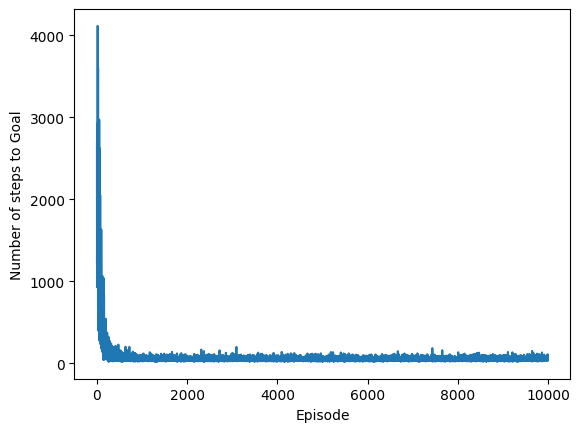

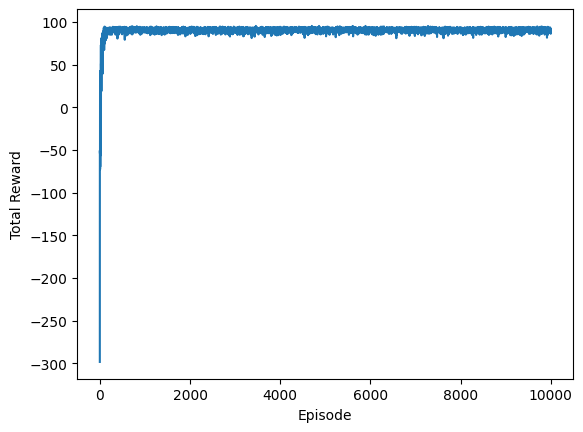

In [ ]:
plt.xlabel('Episode')
plt.ylabel('Number of steps to Goal')
plt.plot(np.arange(episodes),np.average(sarsa_steps_avgs, 0))
plt.show()
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.plot(np.arange(episodes),np.average(sarsa_reward_avgs, 0))
plt.show()

## TODO: Q-Learning
Now, implement the Q-Learning algorithm as an exercise.

Recall the update rule for Q-Learning:
\begin{equation}
Q(s_t,a_t) \leftarrow  Q(s_t, a_t) + \alpha[r_t + \gamma \max_a Q(s_{t+1}, a) - Q(s_t, a_t)]
\end{equation}

Visualize and compare results with SARSA. Repeat experiments 5 times (as in SARSA) and report average number of steps to goal and average episodic reward. You may use the same hyperparameters as SARSA.

In [ ]:
print_freq = 100

def Q_learning(env, Q, gamma=0.9, plot_heat=False, choose_action=choose_action_softmax,episodes = 10000):

    episode_rewards = np.zeros(episodes)
    steps_to_completion = np.zeros(episodes)

    if plot_heat:
        clear_output(wait=True)
        plot_Q(Q)

    epsilon = epsilon0
    alpha = alpha0

    for ep in tqdm(range(episodes)):
        tot_reward, steps = 0, 0

        # Reset environment
        state = env.reset()
        done = False

        while not done:
            action = choose_action(Q, state)
            state_next, reward, done = env.step(action)

            # Q-learning update equation
            Q[state[0], state[1], action] += alpha * (reward + gamma * np.max(Q[state_next[0], state_next[1], :]) - Q[state[0], state[1], action])

            tot_reward += reward
            steps += 1

            state = state_next

        episode_rewards[ep] = tot_reward
        steps_to_completion[ep] = steps

        if (ep+1) % print_freq == 0 and plot_heat:
            clear_output(wait=True)
            plot_Q(Q, message="Episode %d: Reward: %f, Steps: %.2f, Qmax: %.2f, Qmin: %.2f" % (ep+1, np.mean(episode_rewards[ep-print_freq+1:ep]),np.mean(steps_to_completion[ep-print_freq+1:ep]),Q.max(), Q.min()))

    return Q, episode_rewards, steps_to_completion


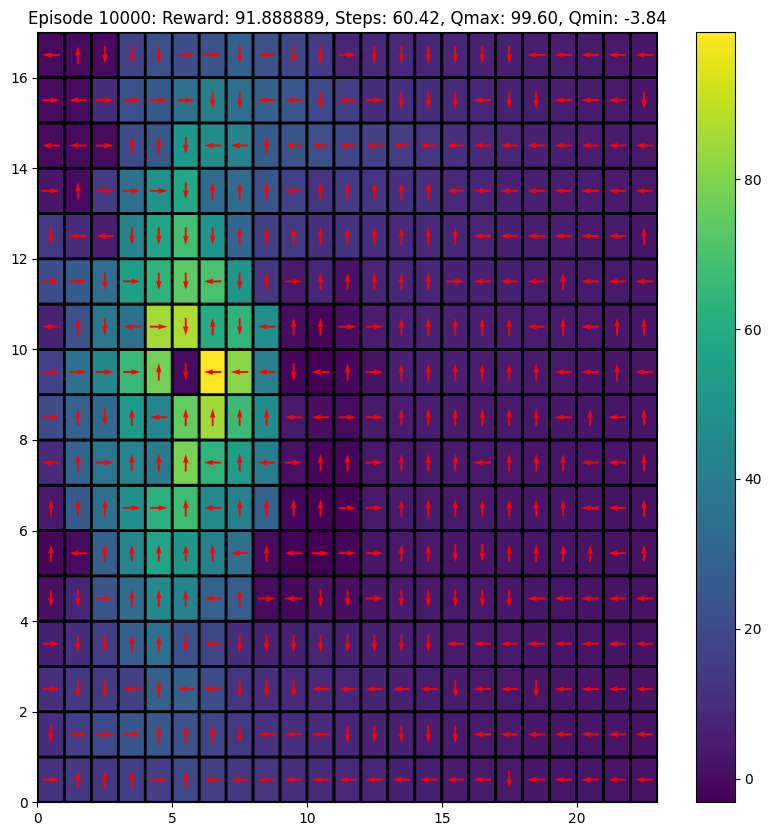

100%|██████████| 10000/10000 [01:20<00:00, 124.51it/s]


In [ ]:
### WRITE CODE HERE ### (visualize policy)
Q_qlearning, rewards, steps = Q_learning(env, Q, gamma = gamma, plot_heat=True, choose_action= choose_action_softmax)


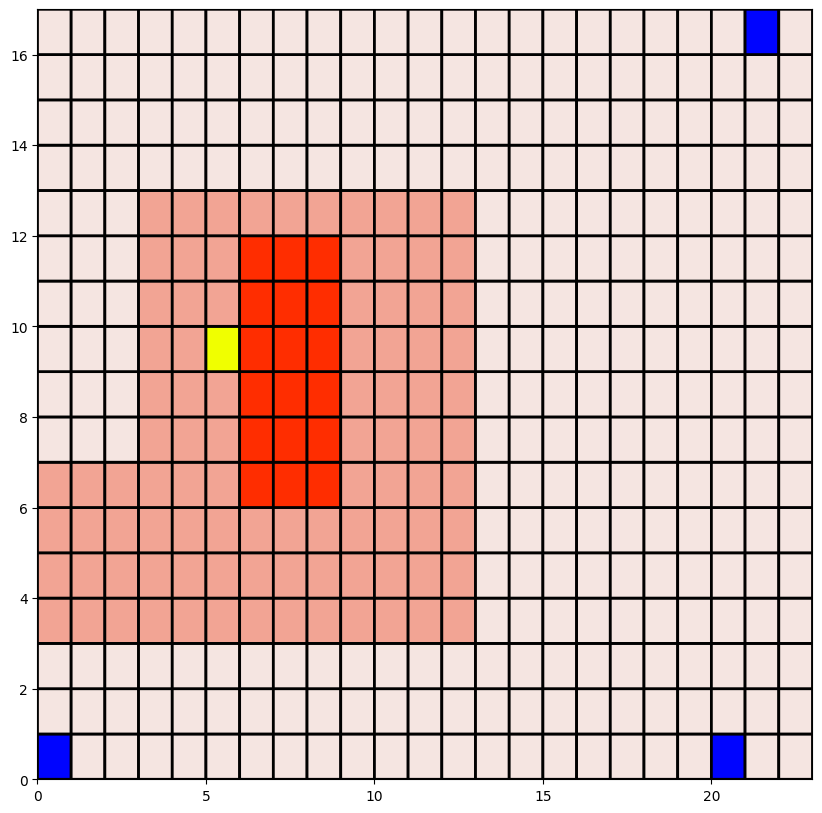

Steps: 24, Total Reward: 91


In [ ]:
from time import sleep

state = env.reset()
done = False
steps = 0
tot_reward = 0
while not done:
    clear_output(wait=True)
    state, reward, done = env.step(Q_qlearning[state[0], state[1]].argmax())
    plt.figure(figsize=(10, 10))
    env.render(ax=plt, render_agent=True)
    plt.show()
    steps += 1
    tot_reward += reward
    sleep(0.2)
print("Steps: %d, Total Reward: %d"%(steps, tot_reward))

In [ ]:
Q_q_avgs, q_reward_avgs, q_steps_avgs = [], [], []
num_expts = 5

for i in range(num_expts):
    print("Experiment: %d"%(i+1))
    Q = np.zeros((env.grid.shape[0], env.grid.shape[1], len(env.action_space)))
    rg = np.random.RandomState(i)
    Q, rewards, steps = Q_learning(env, Q)
    Q_q_avgs.append(Q.copy())
    q_reward_avgs.append(rewards)
    q_steps_avgs.append(steps)

Experiment: 1


100%|██████████| 10000/10000 [01:01<00:00, 162.15it/s]


Experiment: 2


100%|██████████| 10000/10000 [00:51<00:00, 195.14it/s]


Experiment: 3


100%|██████████| 10000/10000 [00:37<00:00, 265.30it/s]


Experiment: 4


100%|██████████| 10000/10000 [00:47<00:00, 209.38it/s]


Experiment: 5


100%|██████████| 10000/10000 [00:49<00:00, 203.90it/s]


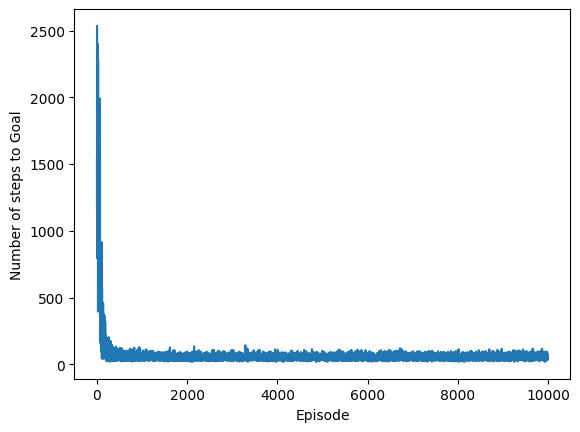

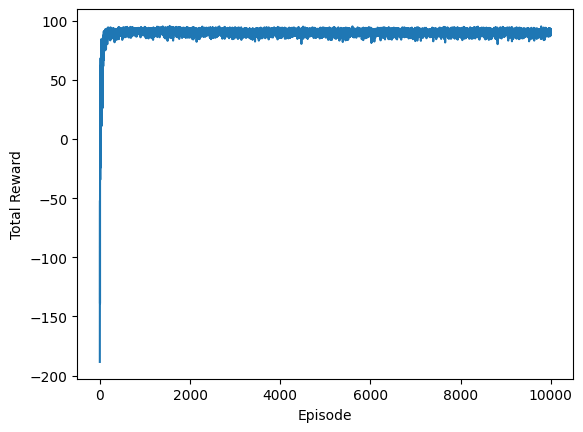

In [ ]:
### WRITE CODE HERE ### (plot metrics avged over 5 runs)

plt.xlabel('Episode')
plt.ylabel('Number of steps to Goal')
plt.plot(np.arange(episodes),np.average(q_steps_avgs, 0))
plt.show()
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.plot(np.arange(episodes),np.average(q_reward_avgs, 0))
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def run_algorithm(env, algorithm, num_expts=5, gamma=0.9, plot_heat=False, choose_action=None, episodes=10000):
    Q_avgs, reward_avgs, steps_avgs = [], [], []
    Q = np.zeros((env.grid.shape[0], env.grid.shape[1], len(env.action_space)))
    Q, rewards, steps = algorithm(env, Q, gamma=gamma, plot_heat=True, choose_action=choose_action, episodes=episodes)
    for i in range(num_expts):
        print(f"Experiment: {i+1}")
        Q = np.zeros((env.grid.shape[0], env.grid.shape[1], len(env.action_space)))
        Q, rewards, steps = algorithm(env, Q, gamma=gamma, plot_heat=False, choose_action=choose_action, episodes=episodes)
        Q_avgs.append(Q.copy())
        reward_avgs.append(rewards)
        steps_avgs.append(steps)
    return np.average(Q_avgs, axis=0), np.average(reward_avgs, axis=0), np.average(steps_avgs, axis=0)

def plot_results(title, xlabel, ylabel, data, label):
    plt.figure()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(np.arange(len(data)), data, label=label)
    plt.legend()
    plt.show()

def sarsa_and_q_learning(env, num_expts=5, gamma=0.9, episodes=10000):

    print("Running sarsa...")
    Q_sarsa, sarsa_rewards, sarsa_steps = run_algorithm(env, sarsa, num_expts, gamma, plot_heat=True, choose_action=choose_action_softmax, episodes=episodes)
    print("Running Q-learning...")
    Q_qlearning, q_rewards, q_steps = run_algorithm(env, Q_learning, num_expts, gamma, plot_heat=True, choose_action=choose_action_softmax, episodes=episodes)


    plot_results("sarsa-Steps to Goal", "Episode", "Number of Steps to Goal", sarsa_steps, "SARSA")
    plot_results("sarsa-Total Reward", "Episode", "Total Reward", sarsa_rewards, "SARSA")
    plot_results("Q-learning-Steps to Goal", "Episode", "Number of Steps to Goal", q_steps, "Q-learning")
    plot_results("Q-learning-Total Reward", "Episode", "Total Reward", q_rewards, "Q-learning")
    plt.figure()
    plt.title("Comparison - Steps to Goal")
    plt.xlabel("Episode")
    plt.ylabel("Number of Steps to Goal")
    plt.plot(np.arange(len(q_steps)), q_steps, label="Q-learning")
    plt.plot(np.arange(len(sarsa_steps)), sarsa_steps, label="sarsa")
    plt.legend()
    plt.show()
    plt.figure()
    plt.title("Comparison - Total Reward")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.plot(np.arange(len(q_rewards)), q_rewards, label="Q-learning")
    plt.plot(np.arange(len(sarsa_rewards)), sarsa_rewards, label="sarsa")
    plt.legend()
    plt.show()
    return (Q_sarsa, sarsa_rewards, sarsa_steps), (Q_qlearning, q_rewards, q_steps)


## TODO: Compare the policies learnt by Q Learning and SARSA and note differences (if any)

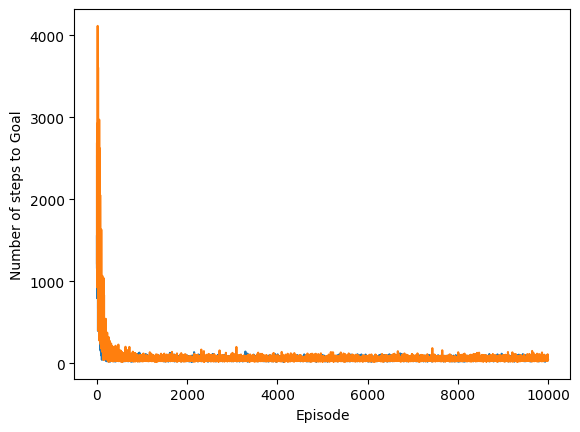

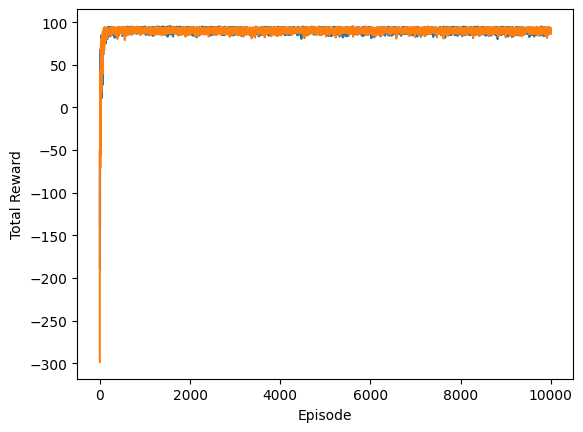

In [ ]:
### WRITE CODE HERE ### (compare Q-Learning and SARSA performance)

plt.xlabel('Episode')
plt.ylabel('Number of steps to Goal')
plt.plot(np.arange(episodes),np.average(q_steps_avgs, 0),label="Qlearning")
plt.plot(np.arange(episodes),np.average(sarsa_steps_avgs, 0),label="sarsa")
plt.legend()
plt.show()
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.plot(np.arange(episodes),np.average(q_reward_avgs, 0),label="Q Learning")
plt.plot(np.arange(episodes),np.average(sarsa_reward_avgs, 0),label="Sarsa")
plt.show()

**Observations:**

The variability in total reward achieved by less is more compared to that of Q learning

Initially the number of steps to goal taken by sarsa is much larger (4000) compared to that of q learning(2500)

## TODO: Repeat your experiments on the windy GridWorld

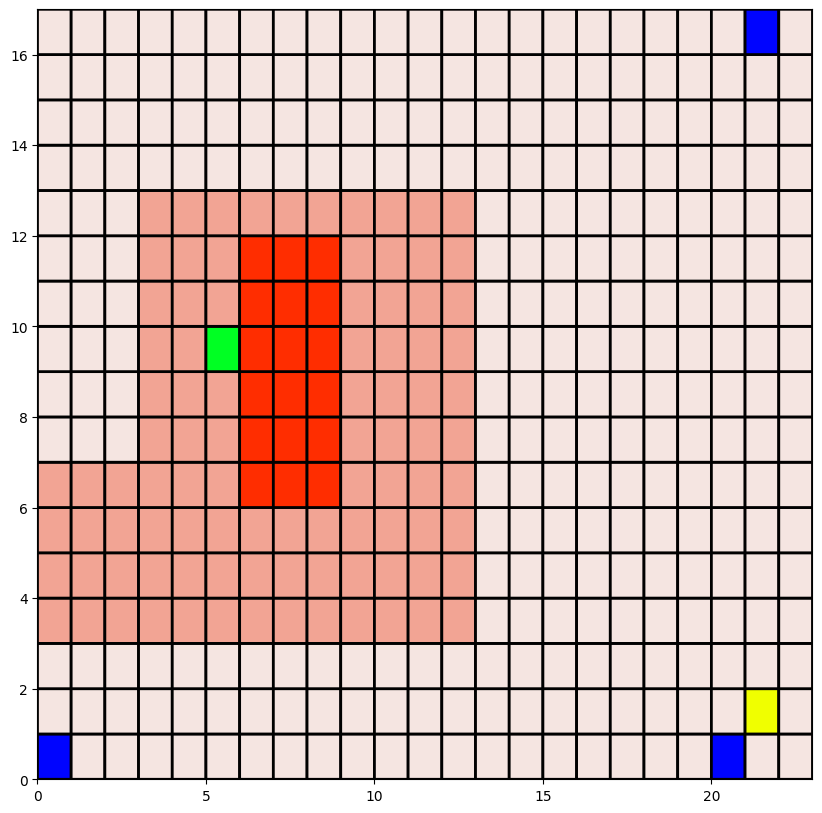

In [ ]:
### WRITE CODE HERE ### (set env to GridWorldWindyEnv)
world = 'grid_world2.txt'
goal_reward = 100
start_states = [(0,0), (0,20), (16,21)]
goal_states=[(9,5)]
max_steps=10000
env = GridWorldWindyEnv(world, goal_reward=goal_reward, start_states=start_states, goal_states=goal_states,
                max_steps=max_steps, action_fail_prob=0.2)
plt.figure(figsize=(10, 10))
# Go UP
env.step(UP)
env.render(ax=plt, render_agent=True)

In [ ]:
# initialize Q-value
Q = np.zeros((env.grid.shape[0], env.grid.shape[1], len(env.action_space)))

alpha0 = 0.4
gamma = 0.9
episodes = 5000
epsilon0 = 0.1

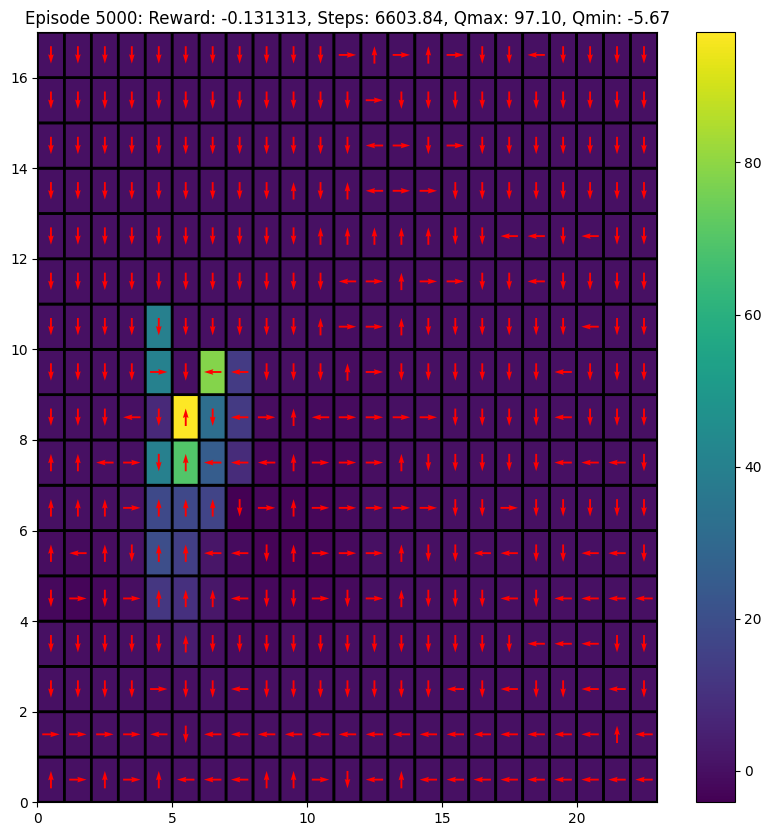

100%|██████████| 5000/5000 [40:46<00:00,  2.04it/s]


Experiment: 1


100%|██████████| 5000/5000 [40:11<00:00,  2.07it/s]


Experiment: 2


100%|██████████| 5000/5000 [40:08<00:00,  2.08it/s]


Experiment: 3


100%|██████████| 5000/5000 [40:06<00:00,  2.08it/s]


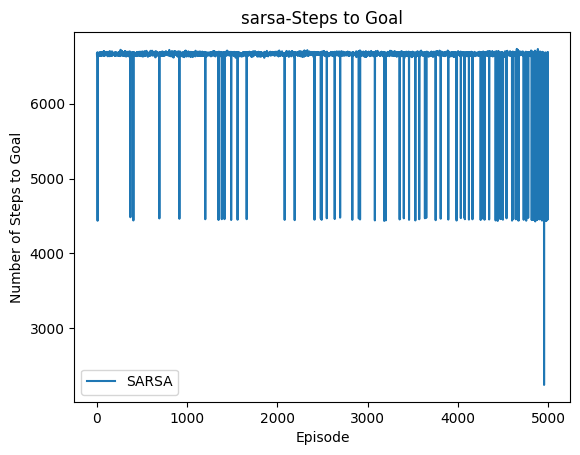

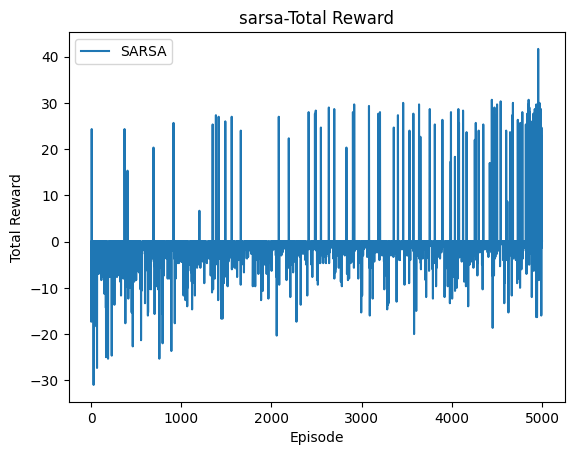

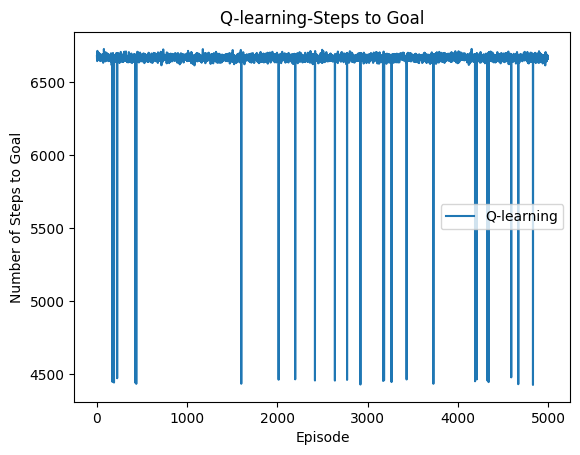

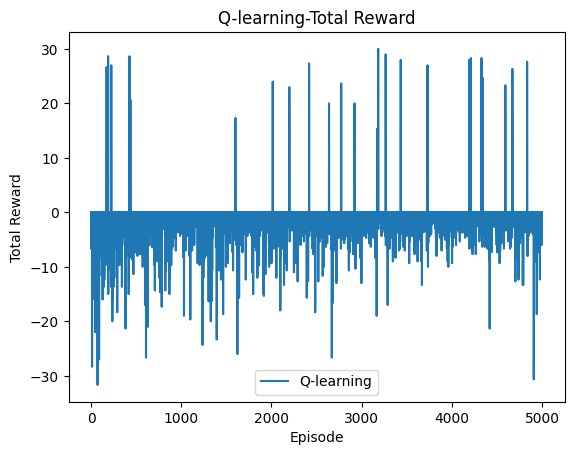

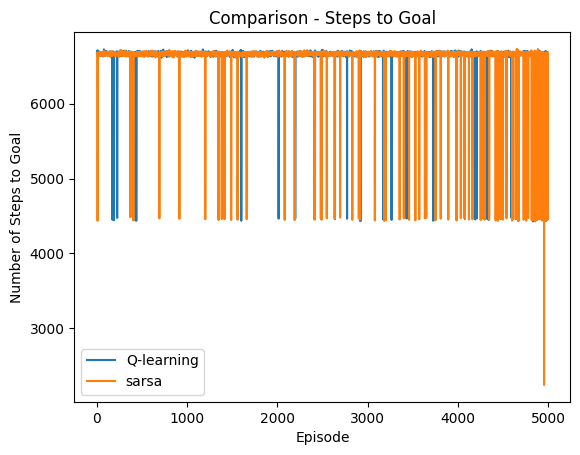

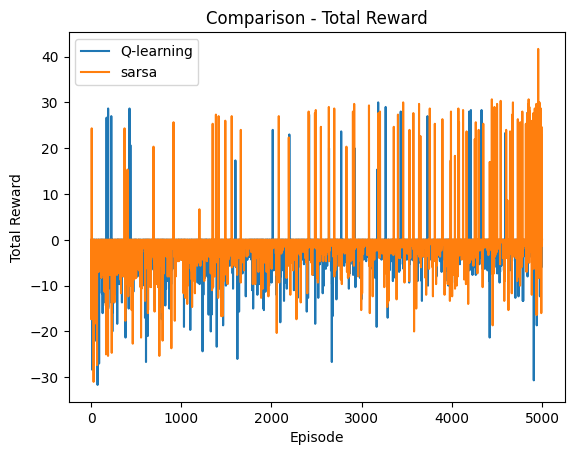

In [ ]:
### WRITE CODE HERE ### (repeat experiments - SARSA)
(Q_sarsa, sarsa_rewards, sarsa_steps), (Q_qlearning, q_rewards, q_steps)=sarsa_and_q_learning(env, num_expts=3, gamma=0.9, episodes=5000)

max timestep 1000

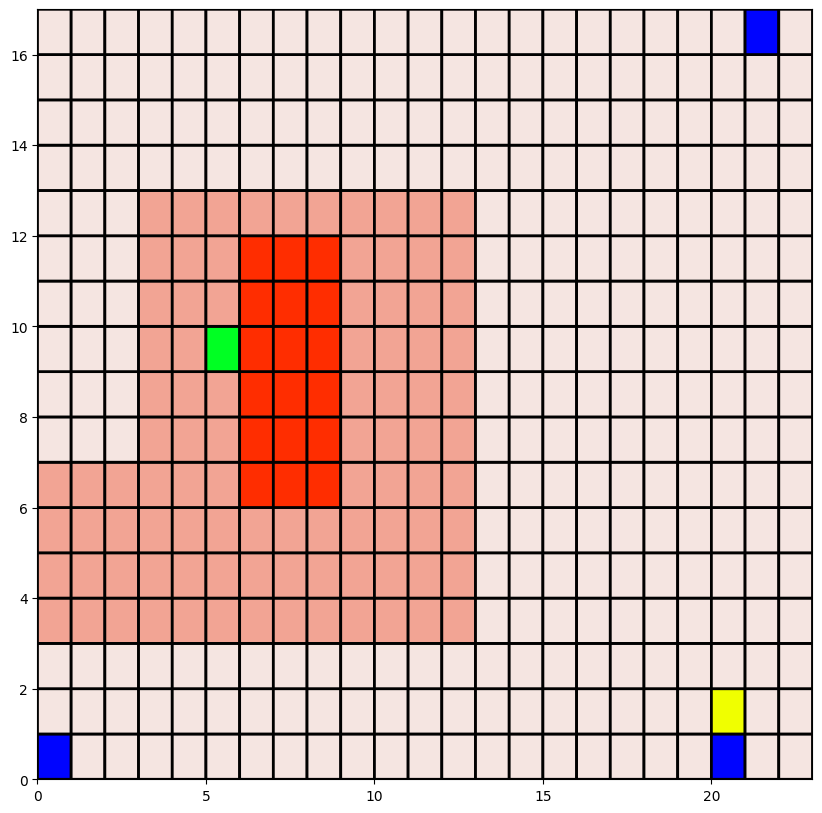

In [ ]:
### WRITE CODE HERE ### (set env to GridWorldWindyEnv)
world = 'grid_world2.txt'
goal_reward = 100
start_states = [(0,0), (0,20), (16,21)]
goal_states=[(9,5)]
max_steps=1000
env = GridWorldWindyEnv(world, goal_reward=goal_reward, start_states=start_states, goal_states=goal_states,
                max_steps=max_steps, action_fail_prob=0.2)
plt.figure(figsize=(10, 10))
# Go UP
env.step(UP)
env.render(ax=plt, render_agent=True)

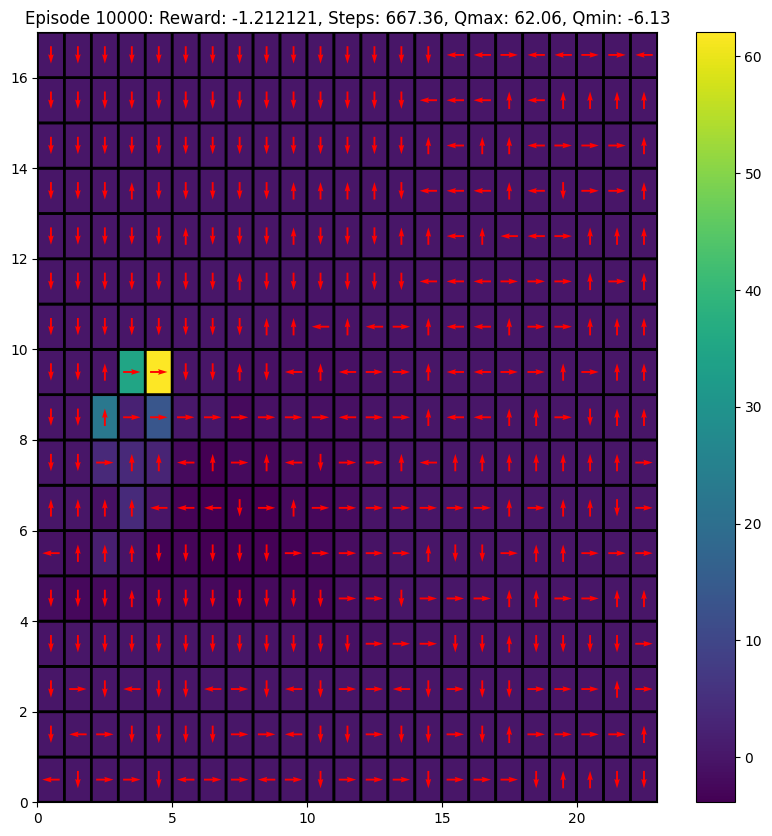

100%|██████████| 10000/10000 [09:14<00:00, 18.03it/s]


Experiment: 1


100%|██████████| 10000/10000 [08:34<00:00, 19.43it/s]


Experiment: 2


100%|██████████| 10000/10000 [08:33<00:00, 19.47it/s]


Experiment: 3


100%|██████████| 10000/10000 [08:29<00:00, 19.63it/s]


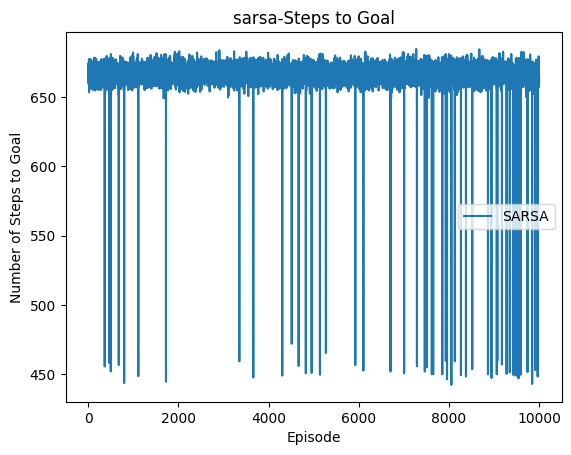

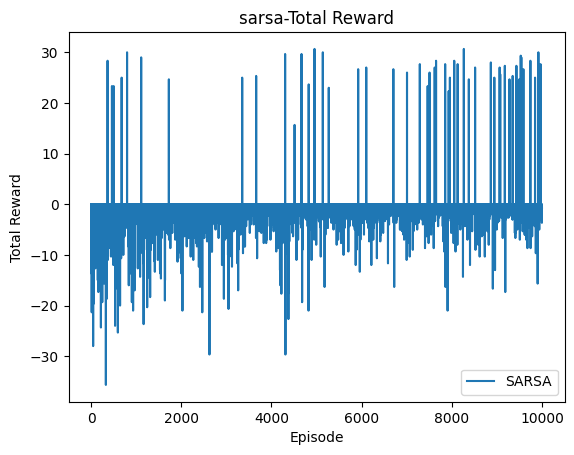

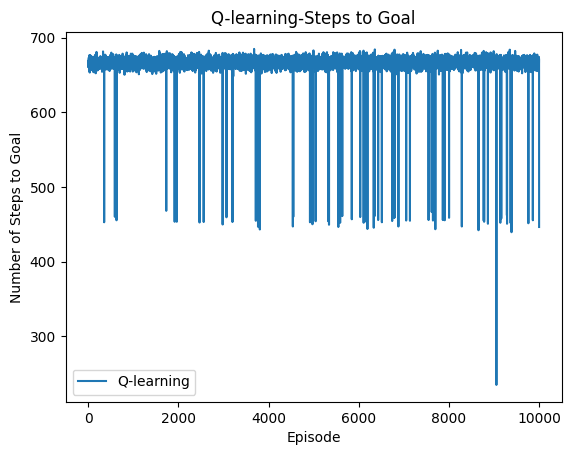

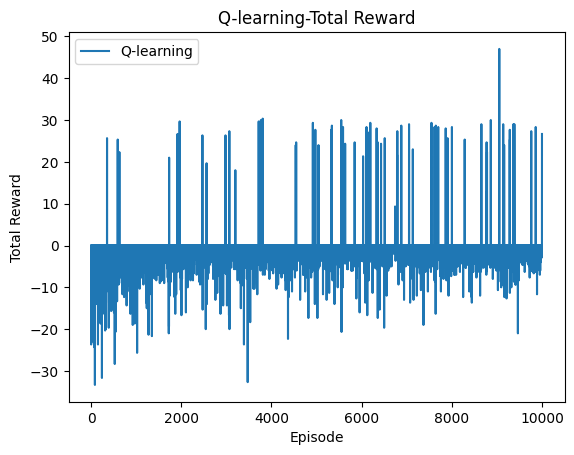

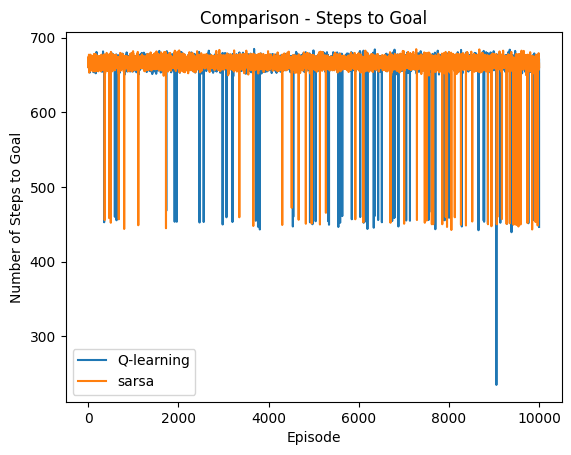

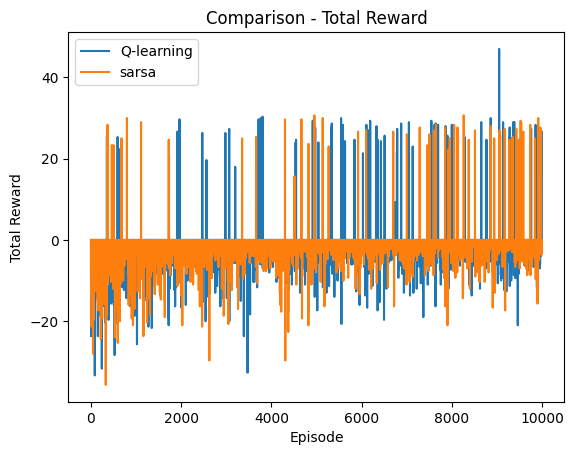

In [ ]:
### WRITE CODE HERE ### (repeat experiments - SARSA)
(Q_sarsa, sarsa_rewards, sarsa_steps), (Q_qlearning, q_rewards, q_steps)=sarsa_and_q_learning(env, num_expts=3, gamma=0.9, episodes=10000)

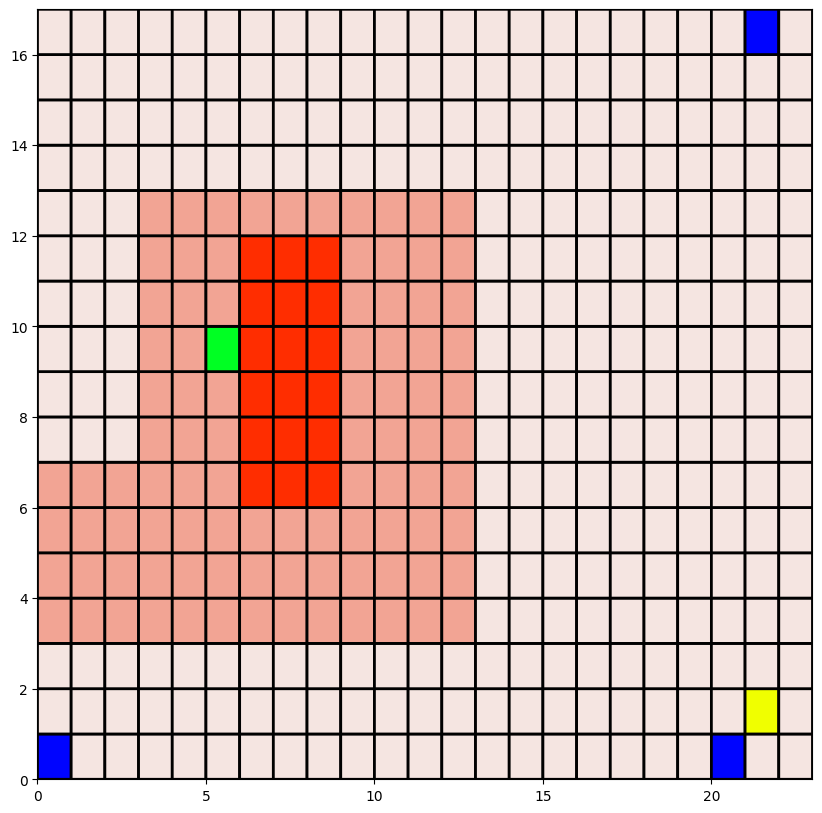

Steps: 657, Total Reward: 0


In [ ]:
from time import sleep

state = env.reset()
done = False
steps = 0
tot_reward = 0
while not done:
    clear_output(wait=True)
    state, reward, done = env.step(Q_sarsa[state[0], state[1]].argmax())
    plt.figure(figsize=(10, 10))
    env.render(ax=plt, render_agent=True)
    plt.show()
    steps += 1
    tot_reward += reward
    sleep(0.2)
print("Steps: %d, Total Reward: %d"%(steps, tot_reward))

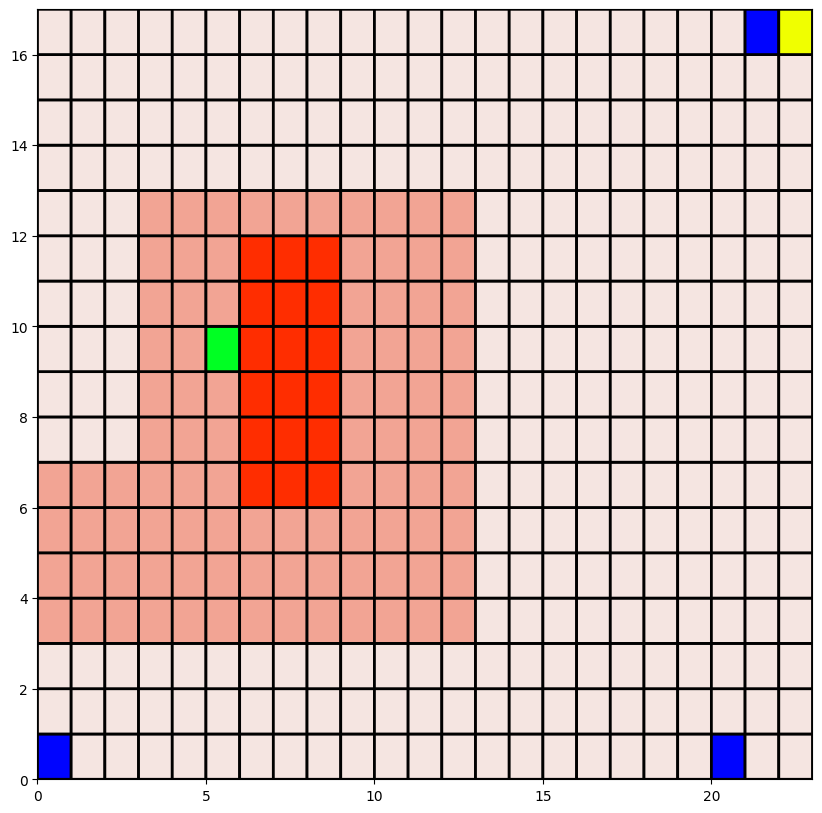

Steps: 672, Total Reward: 0


In [ ]:
from time import sleep

state = env.reset()
done = False
steps = 0
tot_reward = 0
while not done:
    clear_output(wait=True)
    state, reward, done = env.step(Q_qlearning[state[0], state[1]].argmax())
    plt.figure(figsize=(10, 10))
    env.render(ax=plt, render_agent=True)
    plt.show()
    steps += 1
    tot_reward += reward
    sleep(0.2)
print("Steps: %d, Total Reward: %d"%(steps, tot_reward))

### Observation

Because the world is more stochastic compared to the non windy case the it is taking more time to reach the goal state

The 5000 episodes was not sufficiently large for the agent to learn the correct movements from each state

The updates made by sarsa and Q leaning are close to the goal stete

The agent is getting stuch to the right of the world due to the wind

Agent learned a policy such that it mostly avoids red regions so that it can end up finish in 0 reward which is better than the negative reward by visiting red regions giving average reward clost to 0 for most of the time

## Gridworld 1

### Non windy

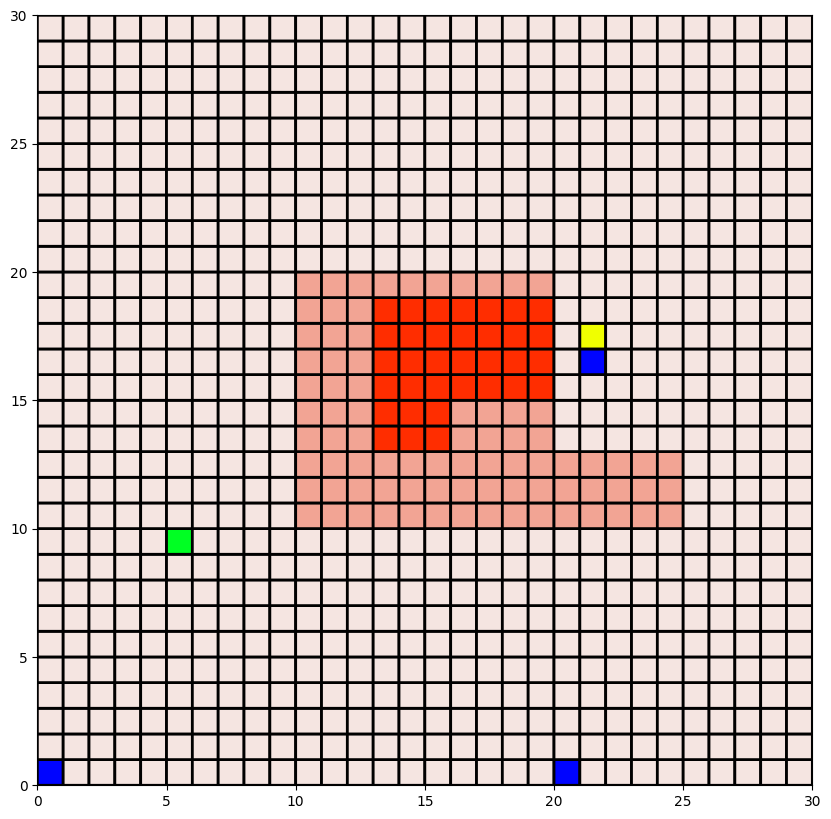

In [ ]:
world = 'grid_world1.txt'
goal_reward = 100
start_states = [(0,0), (0,20), (16,21)]
goal_states=[(9,5)]
max_steps=10000

from grid_world import GridWorldEnv, GridWorldWindyEnv

env = GridWorldEnv(world, goal_reward=goal_reward, start_states=start_states, goal_states=goal_states,
                max_steps=max_steps, action_fail_prob=0.2)
plt.figure(figsize=(10, 10))
# Go UP
env.step(UP)
env.render(ax=plt, render_agent=True)

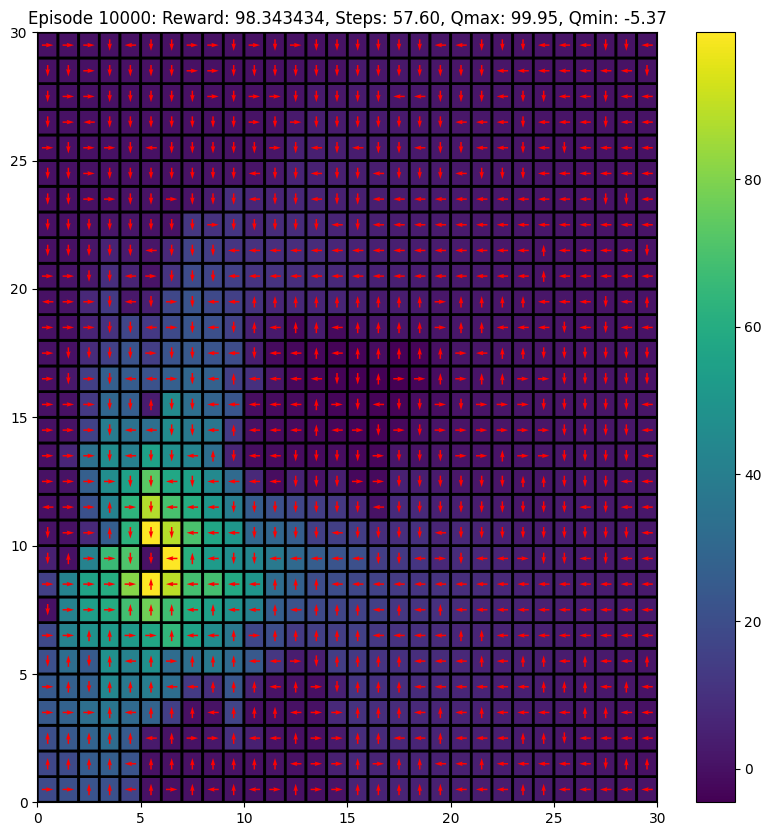

100%|██████████| 10000/10000 [01:46<00:00, 93.65it/s]


Experiment: 1


100%|██████████| 10000/10000 [01:08<00:00, 146.13it/s]


Experiment: 2


100%|██████████| 10000/10000 [00:48<00:00, 204.35it/s]


Experiment: 3


100%|██████████| 10000/10000 [01:18<00:00, 126.64it/s]


Experiment: 4


100%|██████████| 10000/10000 [01:13<00:00, 135.93it/s]


Experiment: 5


100%|██████████| 10000/10000 [01:00<00:00, 165.74it/s]


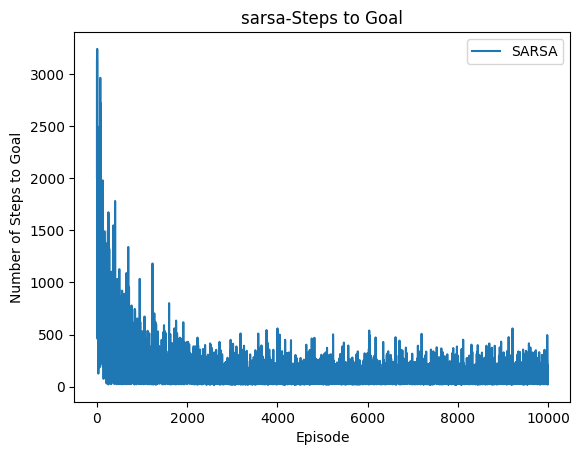

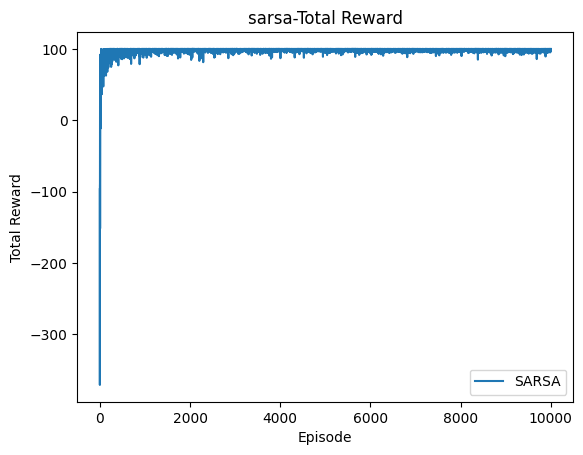

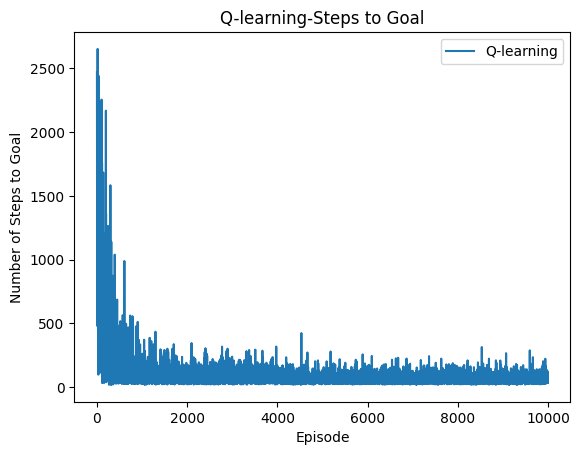

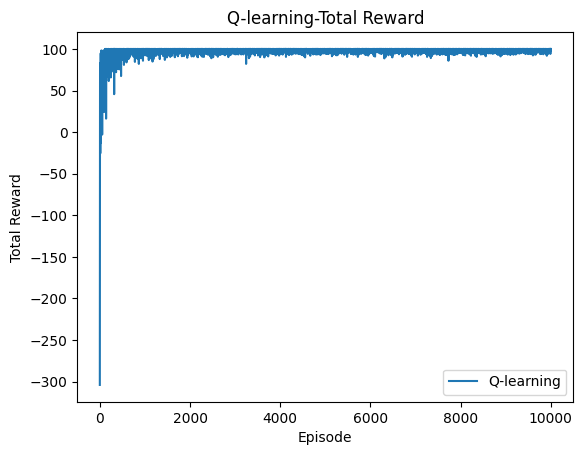

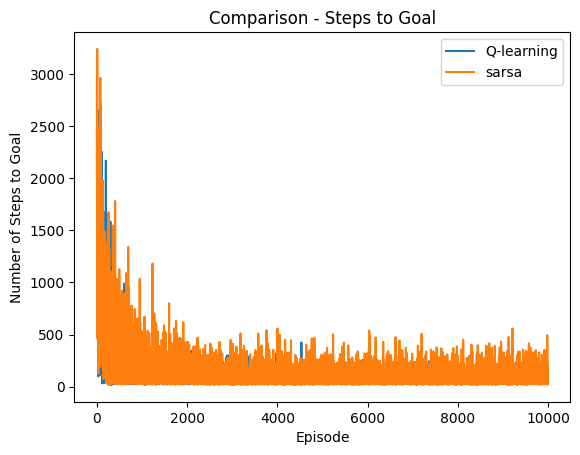

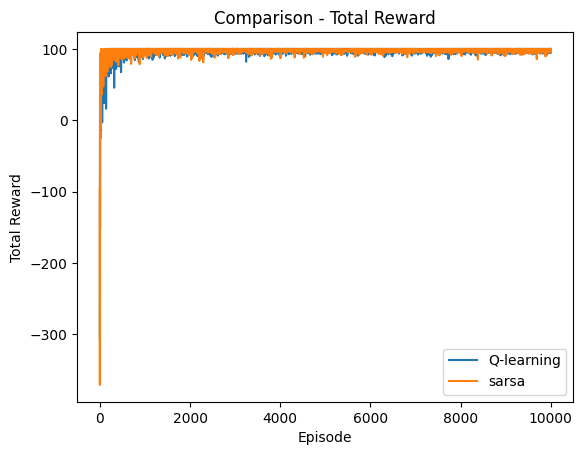

In [ ]:
(Q_sarsa, sarsa_rewards, sarsa_steps), (Q_qlearning, q_rewards, q_steps)=sarsa_and_q_learning(env, num_expts=5, gamma=0.9, episodes=10000)

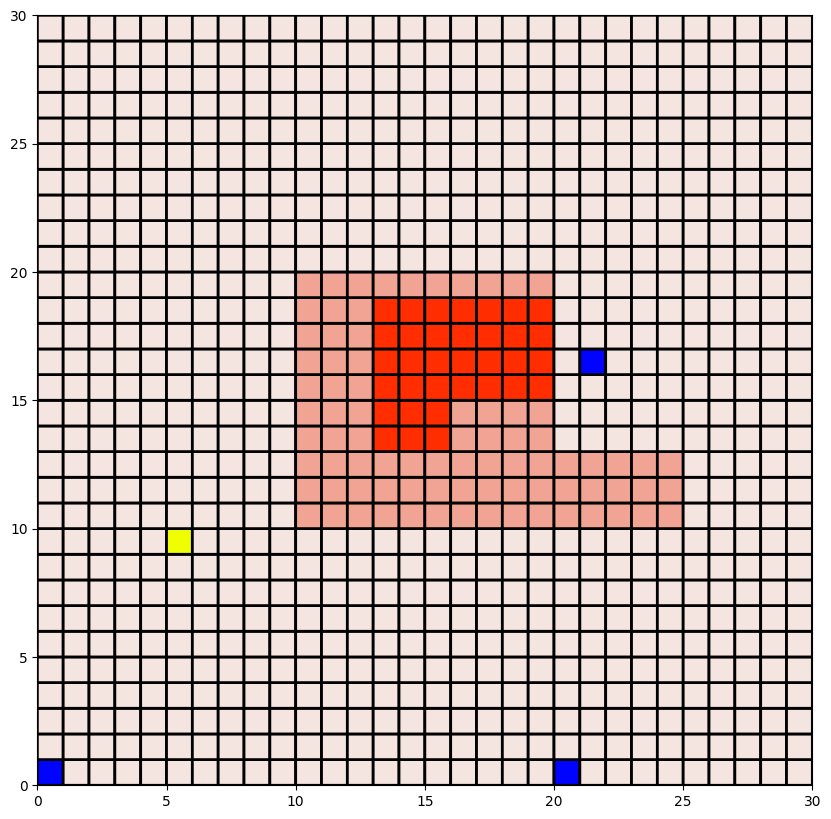

Steps: 47, Total Reward: 98


In [ ]:
from time import sleep

state = env.reset()
done = False
steps = 0
tot_reward = 0
while not done:
    clear_output(wait=True)
    state, reward, done = env.step(Q_sarsa[state[0], state[1]].argmax())
    plt.figure(figsize=(10, 10))
    env.render(ax=plt, render_agent=True)
    plt.show()
    steps += 1
    tot_reward += reward
    sleep(0.2)
print("Steps: %d, Total Reward: %d"%(steps, tot_reward))

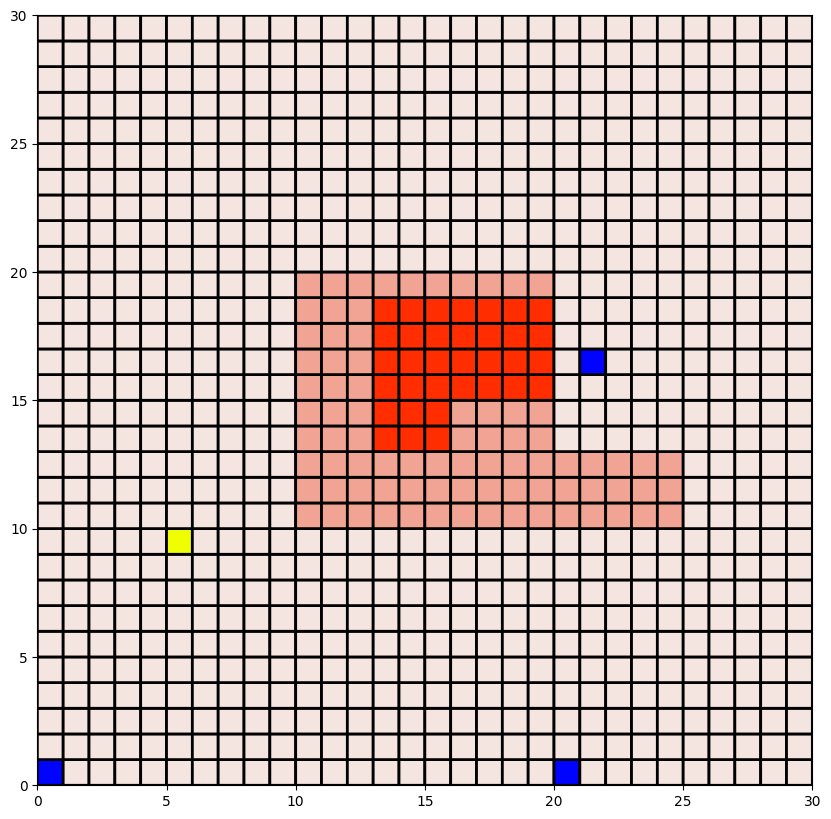

Steps: 22, Total Reward: 100


In [ ]:
from time import sleep

state = env.reset()
done = False
steps = 0
tot_reward = 0
while not done:
    clear_output(wait=True)
    state, reward, done = env.step(Q_qlearning[state[0], state[1]].argmax())
    plt.figure(figsize=(10, 10))
    env.render(ax=plt, render_agent=True)
    plt.show()
    steps += 1
    tot_reward += reward
    sleep(0.2)
print("Steps: %d, Total Reward: %d"%(steps, tot_reward))

## Gridworld

### Non windy

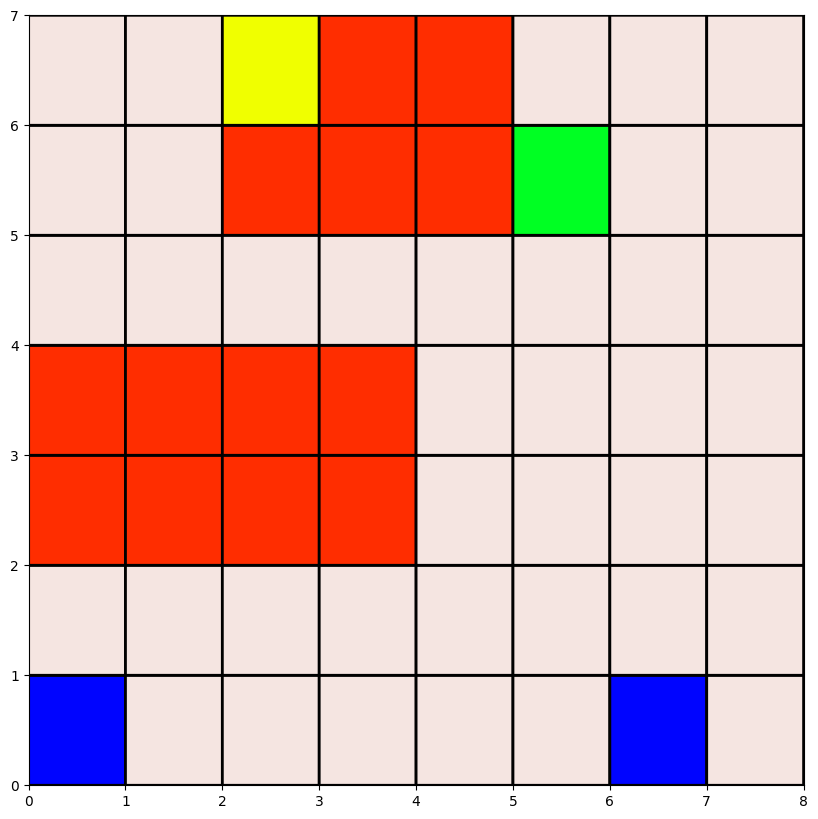

In [ ]:
world = 'grid_world.txt'
goal_reward = 100
start_states = [(0,0), (0,6), (6,2)] ## start and goal given for gridworld 2 is out of bound for gridword
goal_states=[(5,5)]
max_steps=10000

from grid_world import GridWorldEnv, GridWorldWindyEnv

env = GridWorldEnv(world, goal_reward=goal_reward, start_states=start_states, goal_states=goal_states,
                max_steps=max_steps, action_fail_prob=0.2)
plt.figure(figsize=(10, 10))
# Go UP
env.step(UP)
env.render(ax=plt, render_agent=True)

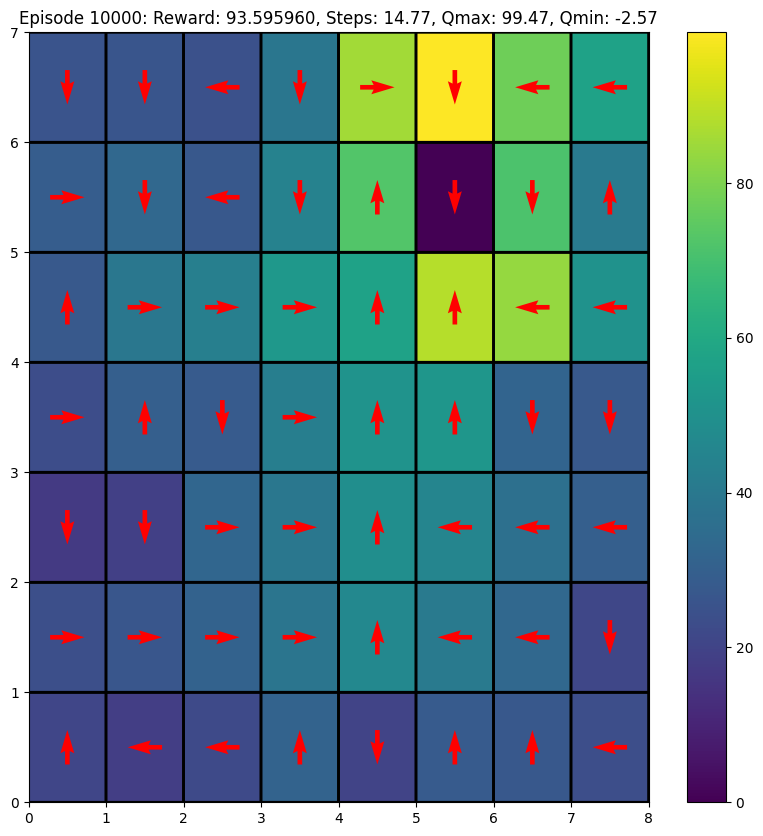

100%|██████████| 10000/10000 [00:49<00:00, 201.94it/s]


Experiment: 1


100%|██████████| 10000/10000 [00:10<00:00, 950.15it/s]


Experiment: 2


100%|██████████| 10000/10000 [00:06<00:00, 1473.31it/s]


Experiment: 3


100%|██████████| 10000/10000 [00:08<00:00, 1130.76it/s]


Experiment: 4


100%|██████████| 10000/10000 [00:08<00:00, 1210.42it/s]


Experiment: 5


100%|██████████| 10000/10000 [00:09<00:00, 1091.80it/s]


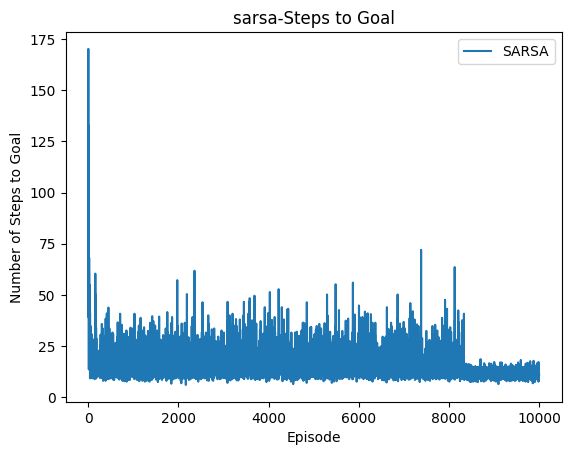

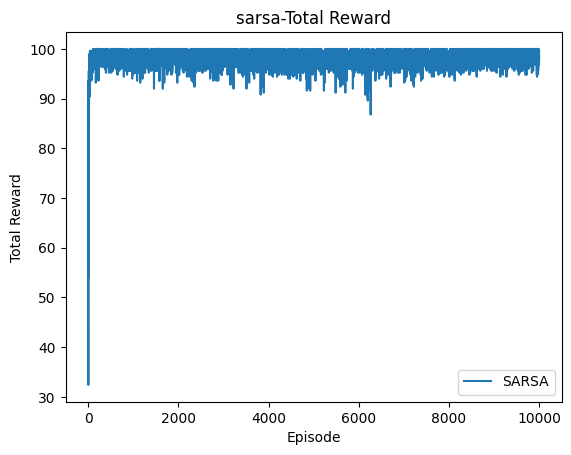

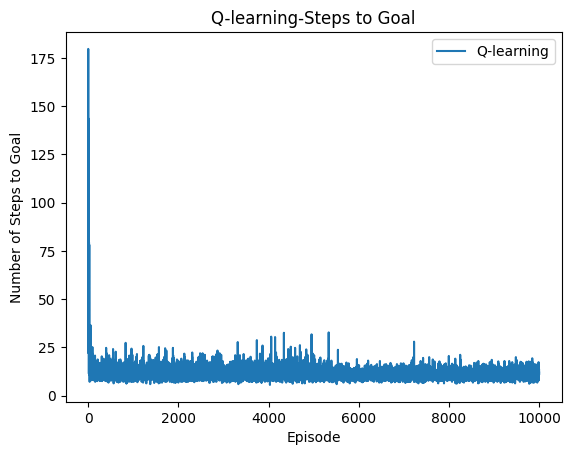

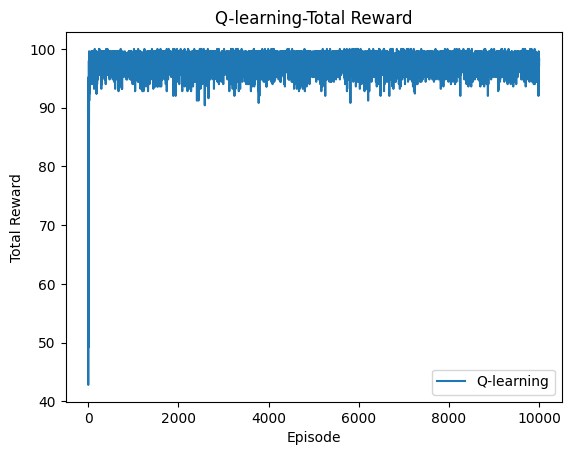

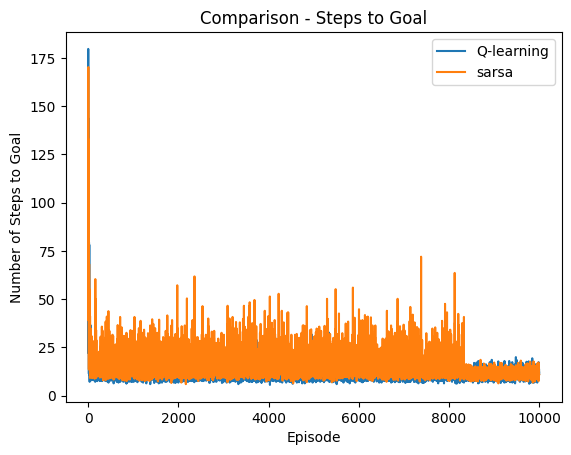

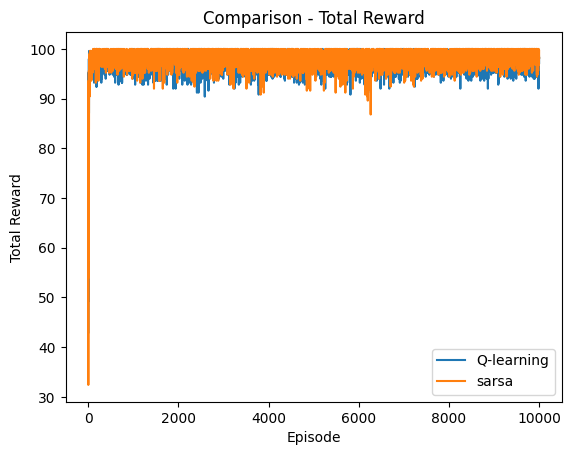

In [ ]:
(Q_sarsa, sarsa_rewards, sarsa_steps), (Q_qlearning, q_rewards, q_steps)=sarsa_and_q_learning(env, num_expts=5, gamma=0.9, episodes=10000)

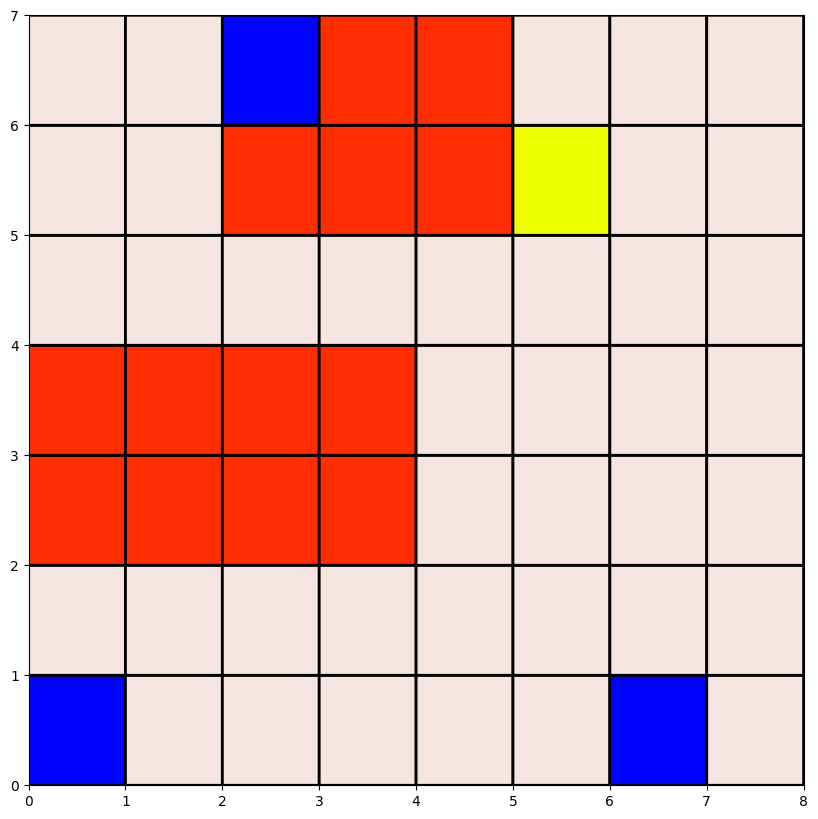

Steps: 6, Total Reward: 98


In [ ]:
from time import sleep

state = env.reset()
done = False
steps = 0
tot_reward = 0
while not done:
    clear_output(wait=True)
    state, reward, done = env.step(Q_sarsa[state[0], state[1]].argmax())
    plt.figure(figsize=(10, 10))
    env.render(ax=plt, render_agent=True)
    plt.show()
    steps += 1
    tot_reward += reward
    sleep(0.2)
print("Steps: %d, Total Reward: %d"%(steps, tot_reward))

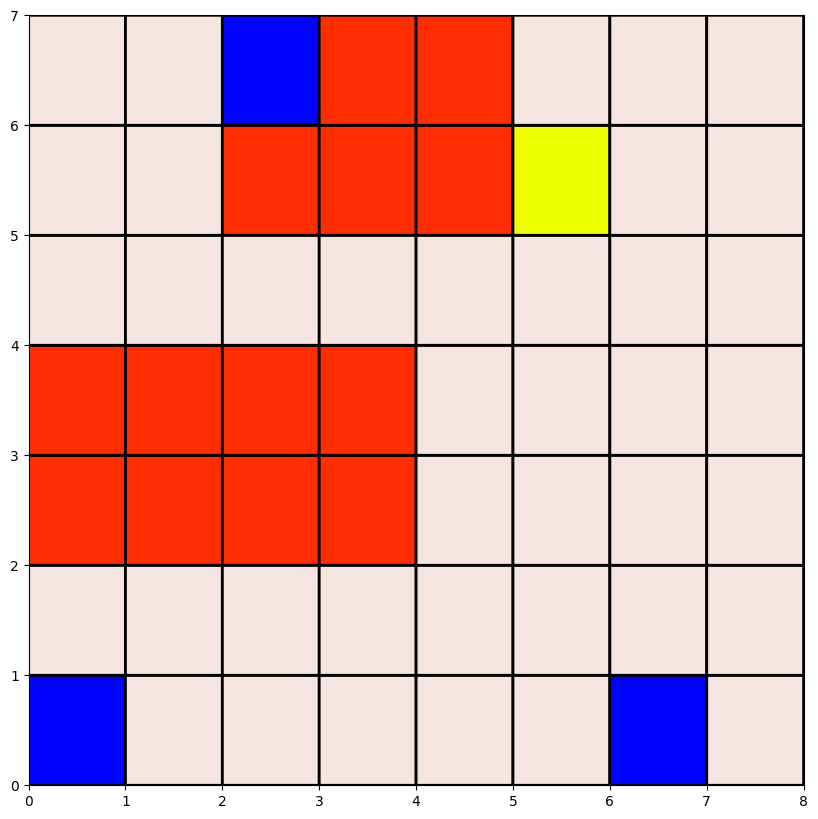

Steps: 14, Total Reward: 100


In [ ]:
from time import sleep

state = env.reset()
done = False
steps = 0
tot_reward = 0
while not done:
    clear_output(wait=True)
    state, reward, done = env.step(Q_qlearning[state[0], state[1]].argmax())
    plt.figure(figsize=(10, 10))
    env.render(ax=plt, render_agent=True)
    plt.show()
    steps += 1
    tot_reward += reward
    sleep(0.2)
print("Steps: %d, Total Reward: %d"%(steps, tot_reward))

#### Obervations
In this experiment we can see that the sarsa upto 8000 steps varies too much compared to Q leaning in number of steps it take to reach goal.

but in case of total reward the Q leaning varies more thatn that of sarsa

### Gridworld windy

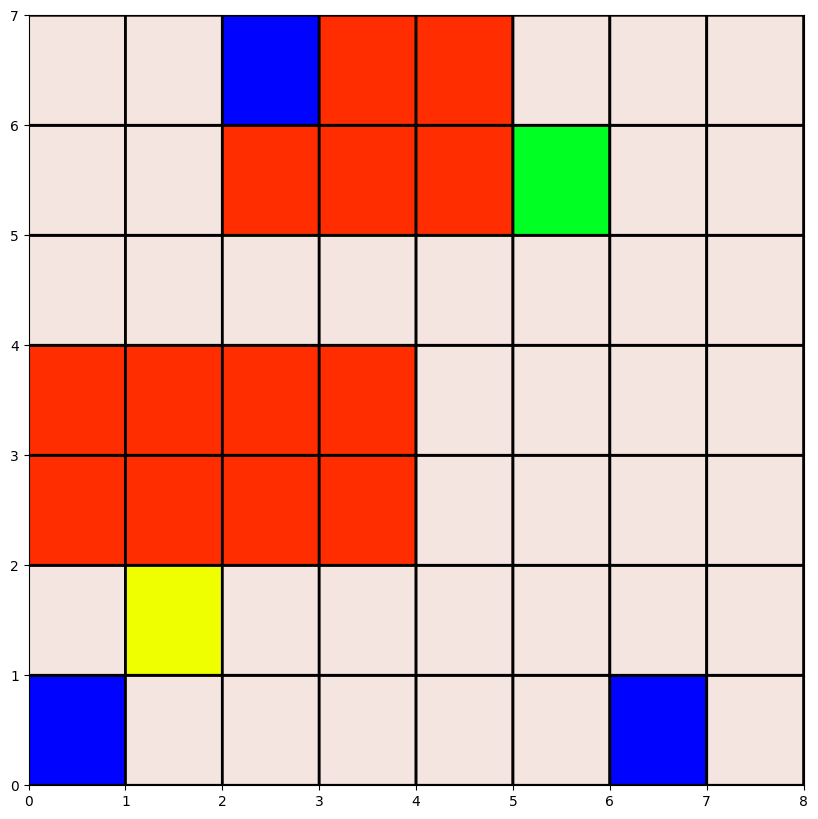

In [ ]:
world = 'grid_world.txt'
goal_reward = 100
start_states = [(0,0), (0,6), (6,2)]
goal_states=[(5,5)]
max_steps=10000

from grid_world import GridWorldEnv, GridWorldWindyEnv

env = GridWorldWindyEnv(world, goal_reward=goal_reward, start_states=start_states, goal_states=goal_states,
                max_steps=max_steps, action_fail_prob=0.2)
plt.figure(figsize=(10, 10))
# Go UP
env.step(UP)
env.render(ax=plt, render_agent=True)

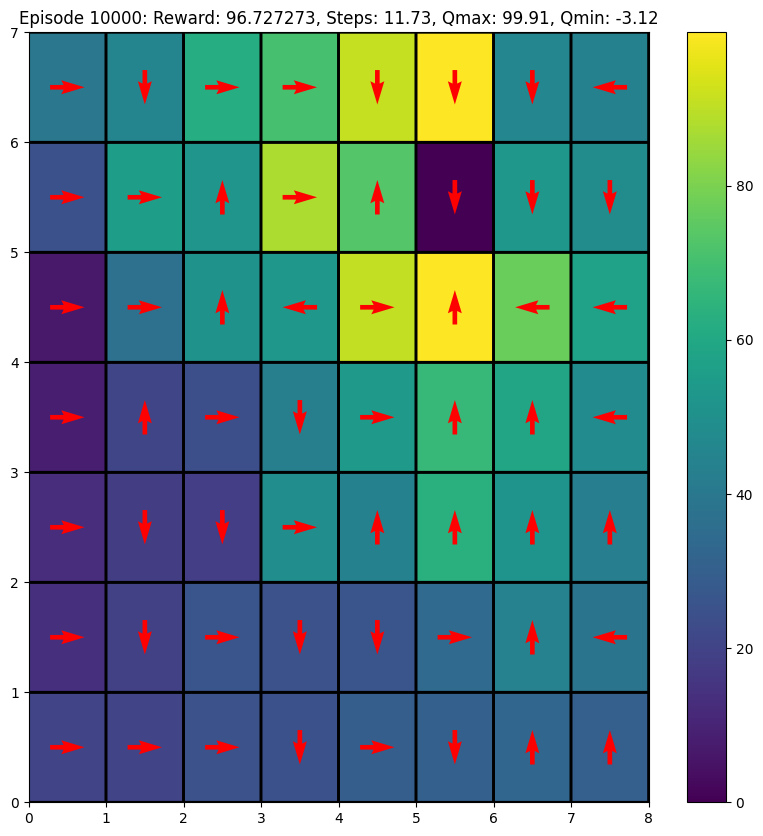

100%|██████████| 10000/10000 [00:47<00:00, 209.14it/s]


Experiment: 1


100%|██████████| 10000/10000 [00:09<00:00, 1039.74it/s]


Experiment: 2


100%|██████████| 10000/10000 [00:18<00:00, 531.07it/s]


Experiment: 3


100%|██████████| 10000/10000 [00:10<00:00, 992.78it/s]


Experiment: 4


100%|██████████| 10000/10000 [00:09<00:00, 1050.65it/s]


Experiment: 5


100%|██████████| 10000/10000 [00:09<00:00, 1057.39it/s]


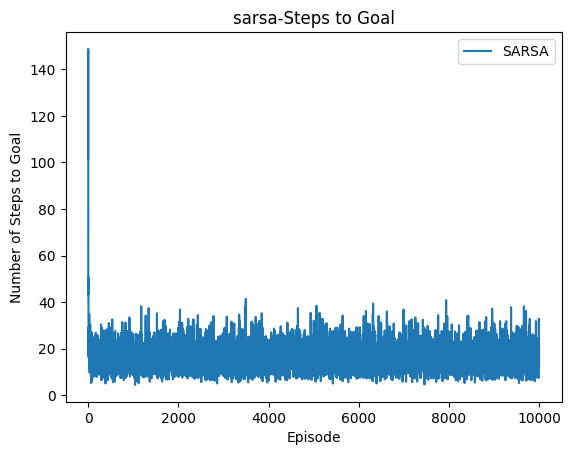

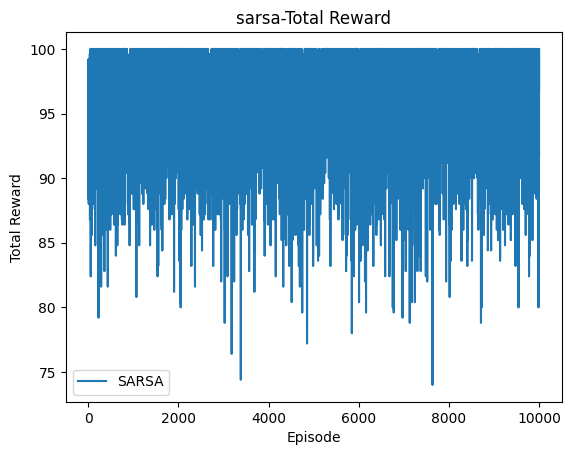

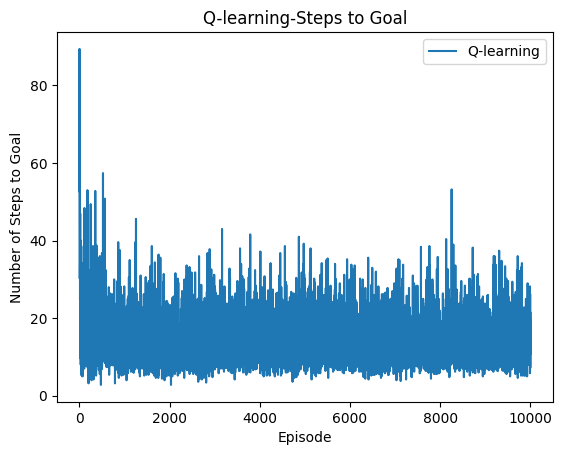

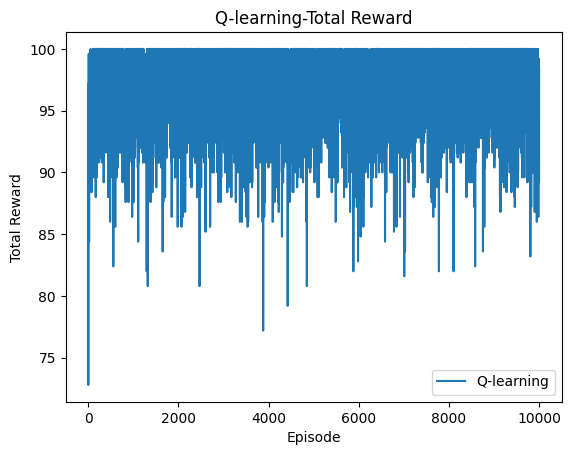

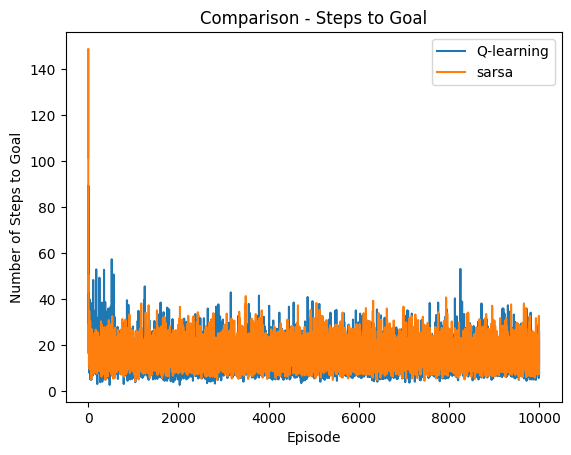

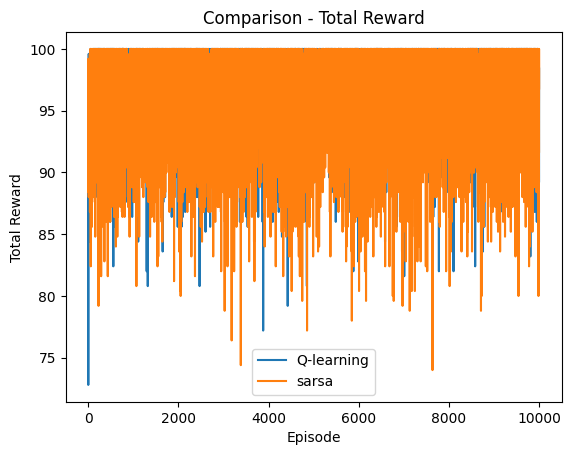

In [ ]:
(Q_sarsa, sarsa_rewards, sarsa_steps), (Q_qlearning, q_rewards, q_steps)=sarsa_and_q_learning(env, num_expts=5, gamma=0.9, episodes=10000)

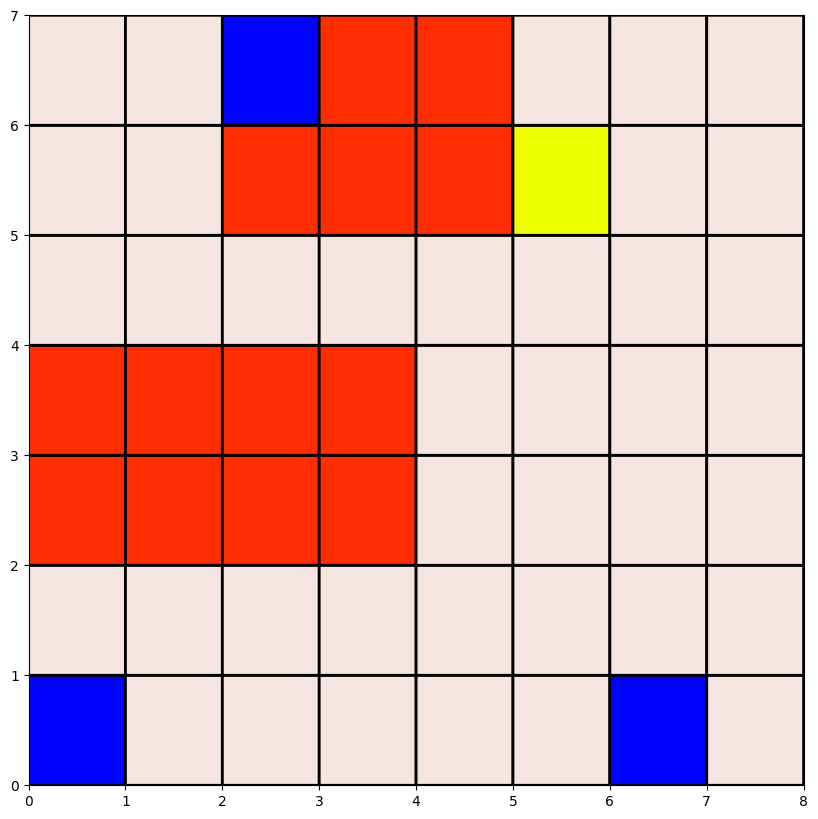

Steps: 6, Total Reward: 94


In [ ]:
from time import sleep

state = env.reset()
done = False
steps = 0
tot_reward = 0
while not done:
    clear_output(wait=True)
    state, reward, done = env.step(Q_sarsa[state[0], state[1]].argmax())
    plt.figure(figsize=(10, 10))
    env.render(ax=plt, render_agent=True)
    plt.show()
    steps += 1
    tot_reward += reward
    sleep(0.2)
print("Steps: %d, Total Reward: %d"%(steps, tot_reward))

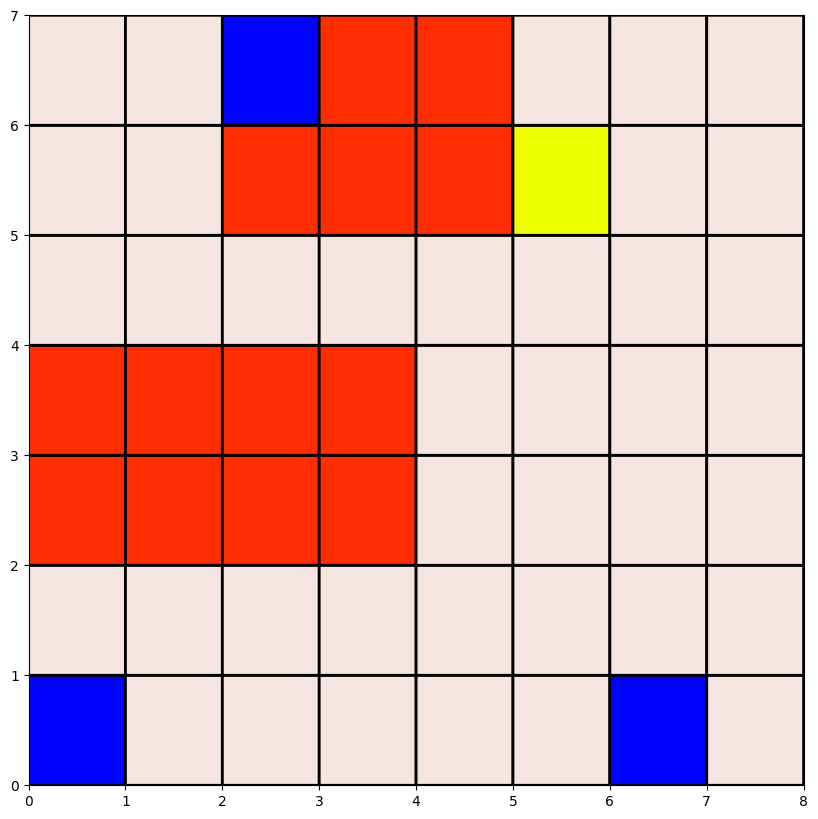

Steps: 6, Total Reward: 100


In [ ]:
from time import sleep

state = env.reset()
done = False
steps = 0
tot_reward = 0
while not done:
    clear_output(wait=True)
    state, reward, done = env.step(Q_qlearning[state[0], state[1]].argmax())
    plt.figure(figsize=(10, 10))
    env.render(ax=plt, render_agent=True)
    plt.show()
    steps += 1
    tot_reward += reward
    sleep(0.2)
print("Steps: %d, Total Reward: %d"%(steps, tot_reward))

#### observations
Due to the wind the environment is more stocastic which leads to more variabilit in the number of steps taken as well as the total reward obtained

In this casse the number of steps taken by sarsa in less varying when compared to that of q learning

In [ ]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono fonts-texgyre
  fonts-urw-base35 libapache-pom-java libcmark-gfm-extensions0.29.0.gfm.3 libcmark-gfm0.29.0.gfm.3
  libcommons-logging-java libcommons-parent-java libfontbox-java libfontenc1 libgs9 libgs9-common
  libidn12 libijs-0.35 libjbig2dec0 libkpathsea6 libpdfbox-java libptexenc1 libruby3.0 libsynctex2
  libteckit0 libtexlua53 libtexluajit2 libwoff1 libzzip-0-13 lmodern pandoc-data poppler-data
  preview-latex-style rake ruby ruby-net-telnet ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0
  rubygems-integration t1utils teckit tex-common tex-gyre texlive-base texlive-binaries
  texlive-fonts-recommended texlive-latex-base texlive-latex-recommended texlive-pictures
  texlive-plain-generic tipa xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-fre

In [ ]:
!cp "/content/drive/My Drive/Colab Notebooks/CS24M041_QLearning_SARSA.ipynb" ./

In [ ]:
!cp "/content/drive/My Drive/Colab Notebooks/CS24M041_QLearning_SARSA.ipynb" ./

In [ ]:

!jupyter nbconvert --to pdf ./CS24M041_QLearning_SARSA.ipynb

[NbConvertApp] Converting notebook ./CS24M041_QLearning_SARSA.ipynb to pdf
[NbConvertApp] Support files will be in CS24M041_QLearning_SARSA_files/
[NbConvertApp] Making directory ./CS24M041_QLearning_SARSA_files
[NbConvertApp] Writing 145659 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 2103940 bytes to CS24M041_QLearning_SARSA.pdf
